**MIE1624 - Final Exam Project - COVID-19 Vaccination Dataset**

In [1]:
# Import libraries

import numpy as np, pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt, seaborn as sns
import scipy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px
from itertools import product
import statsmodels.api as sm
import datetime
from tqdm import tqdm
from google.colab import files
import io

In [2]:
# Upload dataset

uploader = files.upload()

# loading the dataset 
df = pd.read_csv(io.BytesIO(uploader['Covid19-vaccination.csv']))
print('Shape of data',df.shape)
#see the first five of our dataframe
df.head()

Saving Covid19-vaccination.csv to Covid19-vaccination.csv
Shape of data (63006, 16)


,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003


**Part 1 - Data Cleaning**

In [3]:
# Check how many NAN values there are in the dataset

df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                     27277
people_vaccinated                      28883
people_fully_vaccinated                31853
total_boosters                         56393
daily_vaccinations_raw                 33083
daily_vaccinations                       326
total_vaccinations_per_hundred         27277
people_vaccinated_per_hundred          28883
people_fully_vaccinated_per_hundred    31853
total_boosters_per_hundred             56393
daily_vaccinations_per_million           326
daily_people_vaccinated                 1558
daily_people_vaccinated_per_hundred     1558
dtype: int64

In [4]:
# Drop the rows with NAN values in total vaccinations since it doesn't make sense to include them

df = df.drop(df[df.total_vaccinations.isna()].index)
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                       1879
people_fully_vaccinated                 4751
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

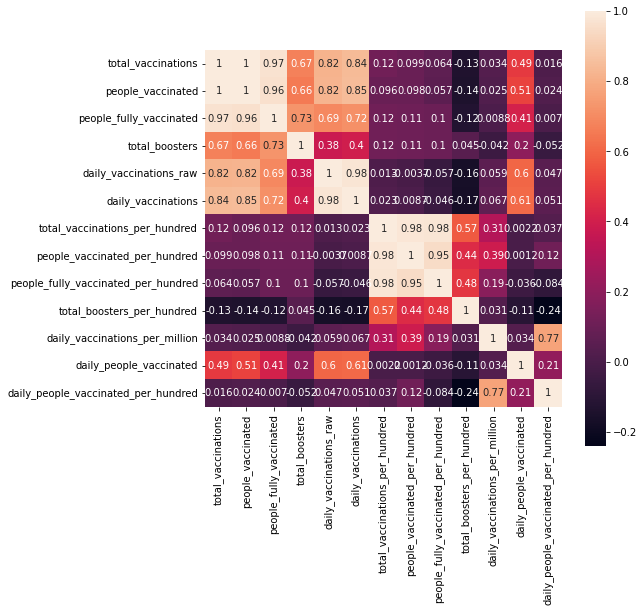

In [5]:
# Correlation matrix
plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

In [6]:
# Fill NANs with 0 to allw us to check p-values for MW and t-tests

check_df = df.copy()
check_df = check_df.fillna(0)
check_df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000
6,Afghanistan,AFG,2021-02-28,8200.0,8200.0,0.0,0.0,0.0,1367.0,0.02,0.02,0.0,0.0,34.0,1367.0,0.003
22,Afghanistan,AFG,2021-03-16,54000.0,54000.0,0.0,0.0,0.0,2862.0,0.14,0.14,0.0,0.0,72.0,2862.0,0.007
44,Afghanistan,AFG,2021-04-07,120000.0,120000.0,0.0,0.0,0.0,3000.0,0.30,0.30,0.0,0.0,75.0,3000.0,0.008
59,Afghanistan,AFG,2021-04-22,240000.0,240000.0,0.0,0.0,0.0,8000.0,0.60,0.60,0.0,0.0,201.0,8000.0,0.020


In [7]:
# Delete the first three columns before MW and t-tests

list_columns = df.columns
list_columns = np.delete(list_columns, 0)
list_columns = np.delete(list_columns, 0)
list_columns = np.delete(list_columns, 0)

In [8]:
list_columns

Index(['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'total_boosters', 'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'daily_vaccinations_per_million', 'daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred'],
      dtype='object')

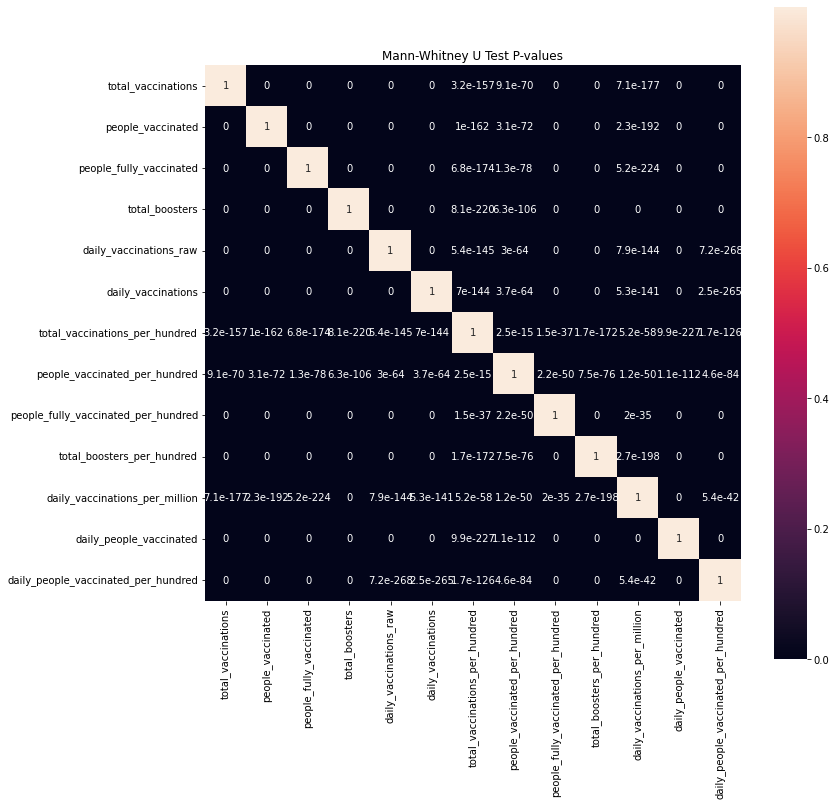

In [9]:
# Ensure alternate  variable in Mann-Whitney U is 2 sided, is p is less than 0.05, reject hypothesis and fill missing value with 0
# Run stat distribution, t-test, if any values are greater than 0.05

from sklearn.preprocessing import StandardScaler
from scipy import stats
temp = []
for i in list_columns:
  temp2 = []
  # Data is standardized before performing Mann-Whitney U Test
  temp_scale = StandardScaler()
  temp_scale2 = StandardScaler()
  for j in list_columns:
    #temp2.append(stats.mannwhitneyu(check_df[i], check_df[j])[1])
    temp2.append(stats.mannwhitneyu(temp_scale.fit_transform(check_df[i].values.reshape(-1,1)), temp_scale2.fit_transform(check_df[j].values.reshape(-1,1)),  alternative='two-sided')[1])
  temp.append(temp2)

plt.subplots(figsize = (12,12))
sns.heatmap(temp, annot=True, square=True, yticklabels=list_columns, xticklabels=list_columns)
plt.title("Mann-Whitney U Test P-values")
plt.show()

All p values for MW test is less than 0.05, so should replace all NANs with 0, this doesn't make sense.

In [10]:
# Sample t-test

from scipy.stats import ttest_ind
print(ttest_ind(check_df['total_vaccinations'], check_df['people_vaccinated']))

Ttest_indResult(statistic=16.93375736857201, pvalue=3.3862860932996894e-64)


As can be seen from our correlation data,  the values of total_vaccinations column are mostly the same as people_vaccinated column. Since p is essentially 0, we can see that the columns are related to one another

In [11]:
# Will perform my own method to fill in missing NAN values
# It looks like total_vaccinated = people_vaccinated + people_fully_vaccinated + total_boosters (based off Canada data)

df.people_vaccinated.fillna(df.total_vaccinations, inplace=True) # There's only a few missing values for people_vaccinated, since they're highly correlated
df.people_fully_vaccinated.fillna(df.total_vaccinations - df.people_vaccinated, inplace=True) # Most of the NAN values are located at the beginning of data collection where boosters were not available yet
df.total_boosters.fillna((df.total_vaccinations - df.people_vaccinated - df.people_fully_vaccinated), inplace=True)

# Repeat same procedures with per hundred, should be the same trend but different ratios based on country population size
df.people_vaccinated_per_hundred.fillna(df.total_vaccinations_per_hundred, inplace=True)
df.people_fully_vaccinated_per_hundred.fillna(df.total_vaccinations_per_hundred - df.people_vaccinated_per_hundred, inplace=True)
df.total_boosters_per_hundred.fillna(df.total_vaccinations_per_hundred - df.people_vaccinated_per_hundred - df.people_fully_vaccinated_per_hundred, inplace=True)
df.isna().sum()

location                                  0
iso_code                                  0
date                                      0
total_vaccinations                        0
people_vaccinated                         0
people_fully_vaccinated                   0
total_boosters                            0
daily_vaccinations_raw                 5806
daily_vaccinations                      235
total_vaccinations_per_hundred            0
people_vaccinated_per_hundred             0
people_fully_vaccinated_per_hundred       0
total_boosters_per_hundred                0
daily_vaccinations_per_million          235
daily_people_vaccinated                 882
daily_people_vaccinated_per_hundred     882
dtype: int64

In [12]:
# Need to replace data with corresponding values, values are less than 0.05 in Mann-Whitney U test, fill values with 0

df.total_boosters.fillna(0)
df.total_boosters_per_hundred.fillna(0)
df.daily_vaccinations_raw = df.daily_vaccinations_raw.fillna(0)
df.daily_vaccinations = df.daily_vaccinations.fillna(0)
df.daily_people_vaccinated = df.daily_people_vaccinated.fillna(0)
df.daily_people_vaccinated_per_hundred = df.daily_people_vaccinated_per_hundred.fillna(0)
df.daily_vaccinations_per_million = df.daily_vaccinations_per_million.fillna(0)
df.isna().sum()

location                               0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
total_boosters                         0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
total_boosters_per_hundred             0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
dtype: int64

In [13]:
#Showing Country name without duplicates.
df['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Eswatini', 'Ethi

# Part 2 - Data Visualization and Exploratory Data Analysis

##Figure 1. Which locations are the most vaccinated?

Vaccines for COVID-19 have been in use from December 2020, and have been implemented in more and more countries over time.

We can observe the locations with the most people vaccinated, however, this doesn't take into account the countries population.

,location,people_vaccinated
0,World,4.197512e+09
1,Asia,2.882381e+09
2,China,2.437252e+09
3,Upper middle income,1.883448e+09
4,Lower middle income,1.390193e+09
...,...,...
230,Montserrat,1.531000e+03
231,Burundi,1.266000e+03
232,Niue,1.202000e+03
233,Tokelau,9.680000e+02


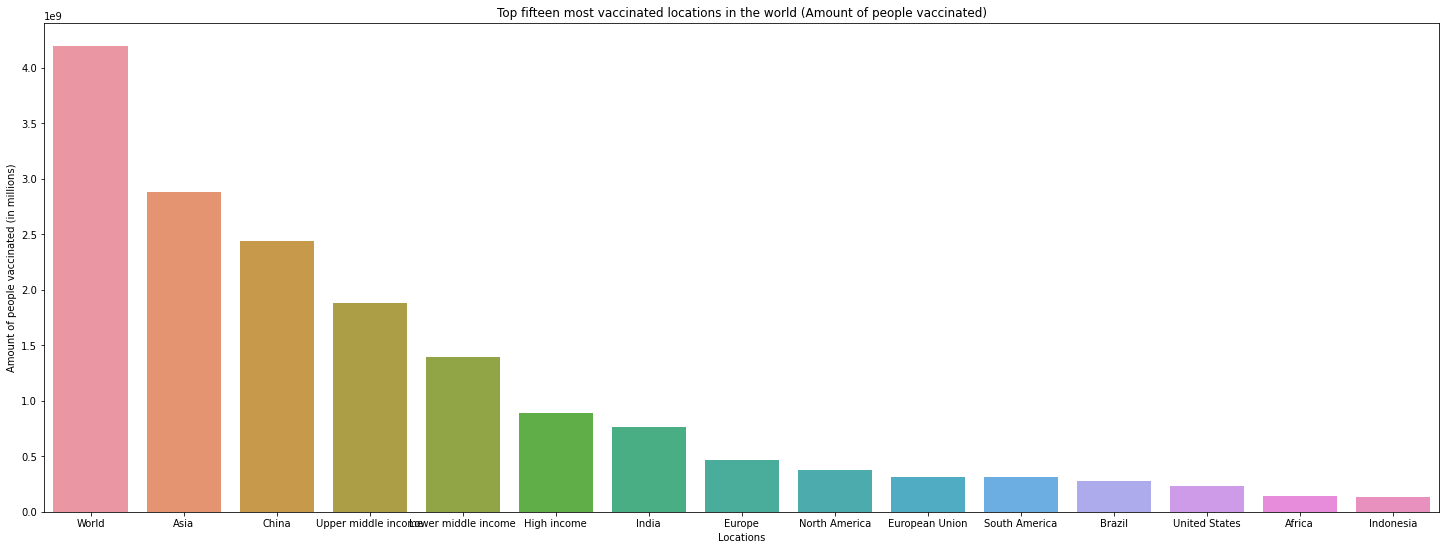

In [14]:
# Grouping the data by country and then sorting the data by the max value from highest to lowest
top_total_vaccinations = df.groupby('location').people_vaccinated.max().sort_values(ascending=False)
total_vaccinations_f = top_total_vaccinations.dropna(axis=0).reset_index() # Dropping NaN values

display(total_vaccinations_f)

# Plotting a barplot for data viz using matplotlib and seaborn
plt.figure(figsize=(25, 9))
plt.title('Top fifteen most vaccinated locations in the world (Amount of people vaccinated)')
sns.barplot(x=total_vaccinations_f.location[0:15], y=total_vaccinations_f['people_vaccinated'])
plt.xlabel('Locations')
plt.ylabel('Amount of people vaccinated (in millions)');

From this, we can see that China and India have the highest number of people vaccinated. This makes sense since those two countries have the largest population. This doesn't necessarily mean it has the highest vaccination rate (the percentage of people vaccinated / total population). The ratio of those vaccinated to those that are not really matters when considering the rate of transmission, and emergence of new variants.

 We can also observe that remote island countries such as Pitcairn has the lowest amount of vaccinated people, this may be due to the remote location of the island and thus lack of resource to safely transfer the vaccine there. 

##Figure 2. Which countries have the most effective vaccination program?

Which countries have the best and most effective vaccination roll out?

We can obseve which countries have the most number of people vaccinated in a single day. This tells us whether vaccines are available in the country and can tell us whether the vaccines are enforced or encouraged by the people in power.

,location,daily_vaccinations
0,World,43233999.0
1,Asia,33335736.0
2,Upper middle income,27439252.0
3,China,22424286.0
4,Lower middle income,16674499.0
...,...,...
230,Burundi,94.0
231,Niue,87.0
232,Montserrat,53.0
233,Tokelau,23.0


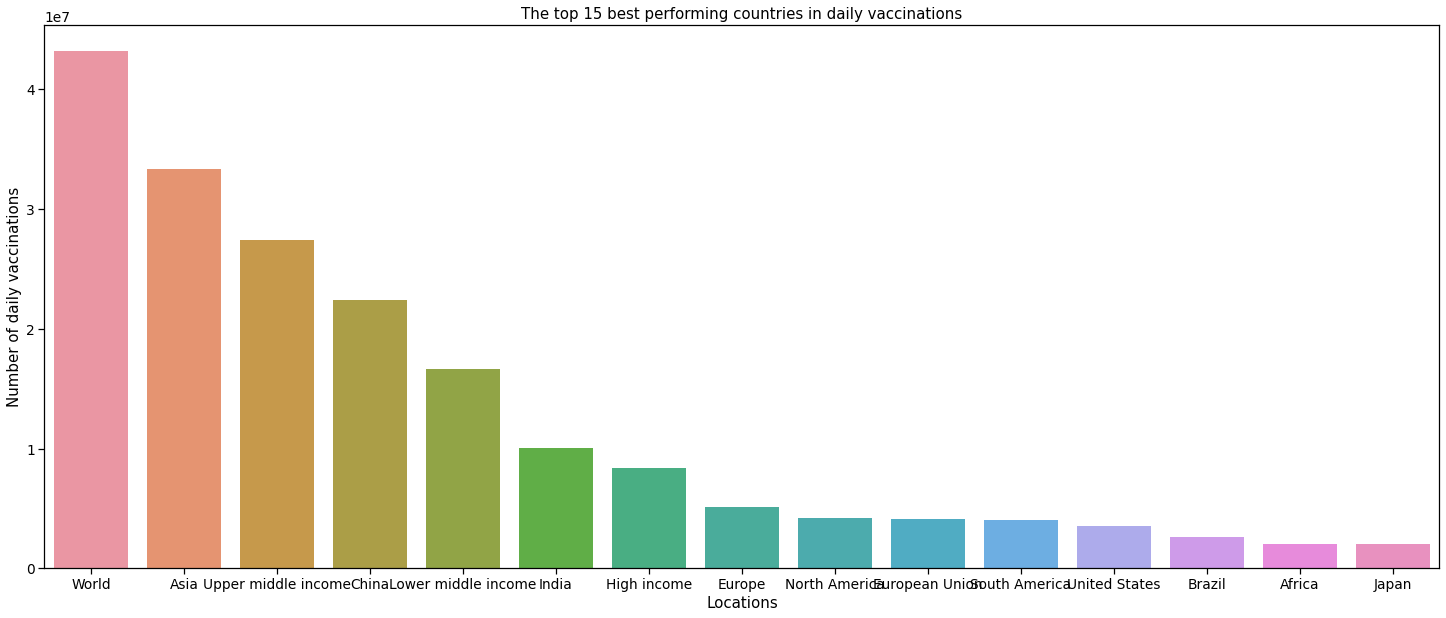

In [15]:
# Grouping the data by country and then sorting the data by the max value from highest to lowest
top_daily = df.groupby('location').daily_vaccinations.max().sort_values(ascending=False)
top_daily_f = top_daily.dropna(axis='rows').reset_index() # Dropping NaN values

display(top_daily_f)

# Plotting the data
with sns.plotting_context('notebook', font_scale = 1.25):
    plt.figure(figsize=(25, 10))
    plt.title('The top 15 best performing countries in daily vaccinations')
    sns.barplot(x=top_daily_f.location[0:15], y=top_daily_f.daily_vaccinations[0:15])
    plt.xlabel('Locations')
    plt.ylabel('Number of daily vaccinations');

We can see that the countries which have a bigger population, more infrastructure and resources and bigger vaccine supply, appear to be becoming more vaccinated as the days go by. It seems like GDP is not a factor here, as many of the majority of the countries are either developing or third-world countries such as India and Brazil. 

##Figure 3. Plotting this data to see the progression in daily vaccinations over time 

We can see the trend of the vaccination rollout overtime for the top 10 countries with the most effective vaccine rollout. 

,location,date,daily_vaccinations
14083,India,2021-01-15,0.0
14383,Indonesia,2021-01-12,0.0
15989,Japan,2021-02-17,0.0
20645,Mexico,2020-12-24,0.0
5948,China,2020-12-15,0.0
...,...,...,...
6059,China,2021-06-29,21993000.0
6054,China,2021-06-24,21998714.0
6056,China,2021-06-26,22105857.0
6057,China,2021-06-27,22366286.0


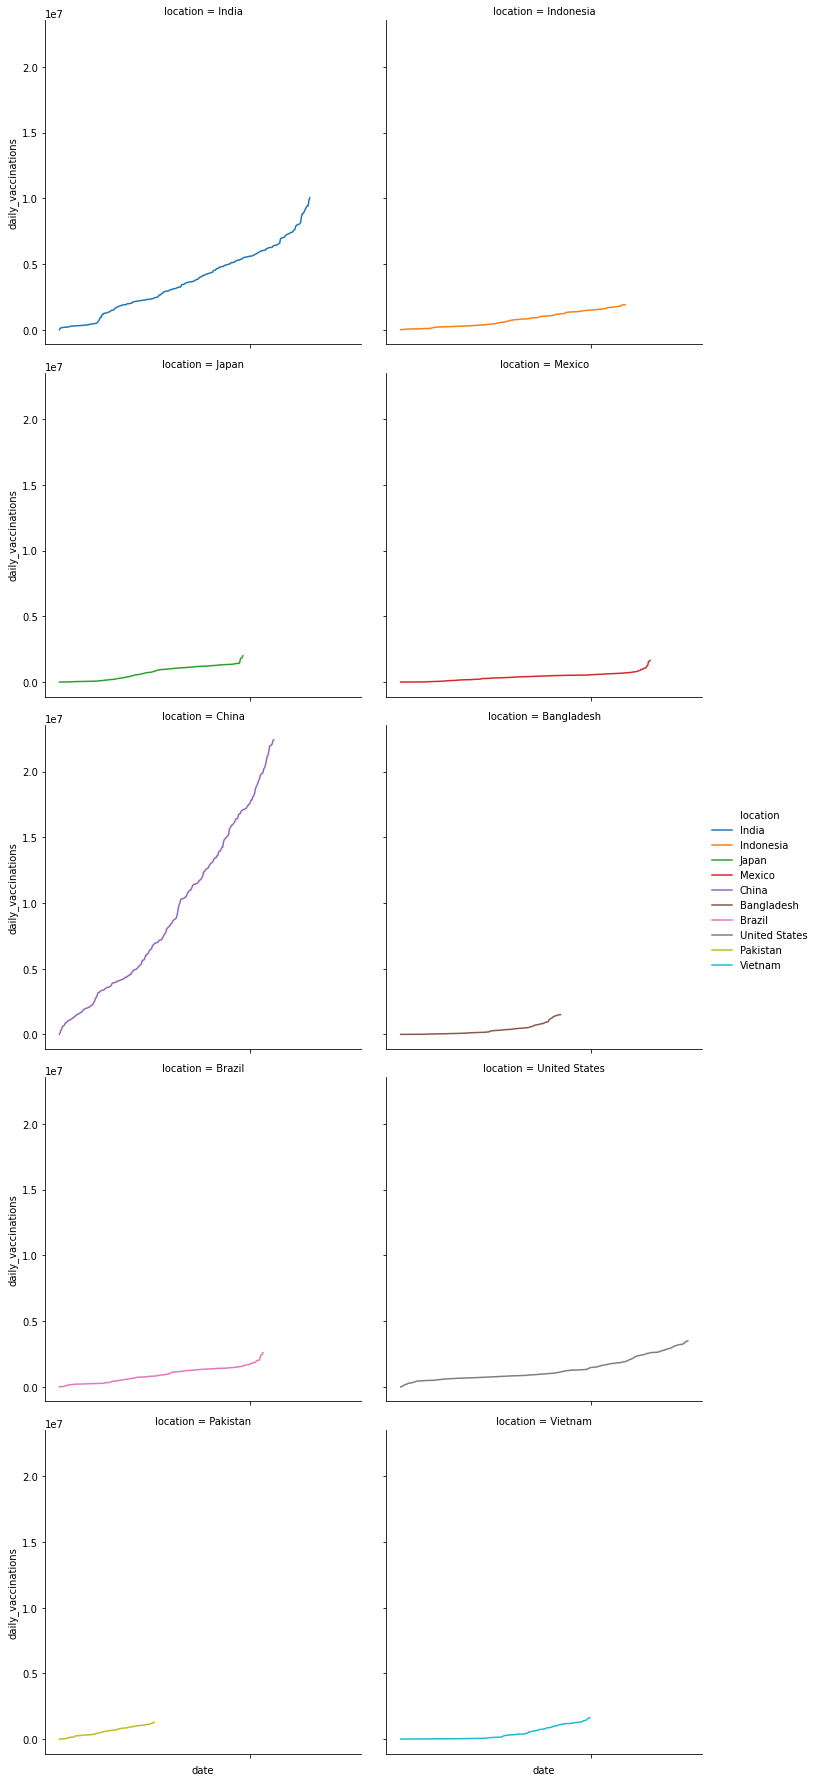

In [16]:
# Establishing which columns are relevant and preparing the dataset
cols = ['location', 'date', 'daily_vaccinations']
covid_df = df.reset_index()

# Creating a list of the aforementioned best performing countries in terms of daily vaccinations
top_10_countries = [
    'China', 'India', 'United States', 'Brazil', 'Japan', 'Indonesia','Mexico', 'Vietnam', 'Bangladesh', 'Pakistan'
]

# Filtering and sorting the data
daily_vacc_df = covid_df[cols].sort_values(by='daily_vaccinations', ascending=True)
top_10_dv_df = daily_vacc_df[daily_vacc_df.location.isin(top_10_countries)].dropna()

display(top_10_dv_df) # verifying that the filtering executed correctly

# Plotting the data in a multi faceted lineplot

#plt.figure(figsize=(18, 32))
sns.relplot(data=top_10_dv_df, x='date', y='daily_vaccinations', hue='location', col='location', kind='line', col_wrap=2)
plt.xticks('');

We can see that China and India are still increasing their vaccination rate exponentially, whilst the US annd Mexico are vaccinating their populations slowly but steadily. This is probably due to the enforcement of mandatory vaccines as well as the availability of vaccines now.

We can also see that the lines for Pakistan and Bangladesh end much earlier than any other country. It seems that the graph stops whenever the daily vaccinations start to decrease, so the graph shows whether the maximum daily vaccination has been reached and if the vaccine rollout has slowed down.

Perhaps their vaccine supplies run out or perhaps those in power have stopped enforcing the vaccines. We can see that for most countries, the rate of vaccination (the slope of the line) is still going up.  

##Figure 4. Plotting vaccination rate of top 10 countries

,location,people_vaccinated_per_hundred
0,Gibraltar,121.37
1,Pitcairn,100.00
2,United Arab Emirates,98.10
3,Singapore,92.99
4,Brunei,90.56
5,Cuba,89.47
6,Portugal,89.04
7,Chile,87.38
8,Cayman Islands,86.25
9,China,84.82


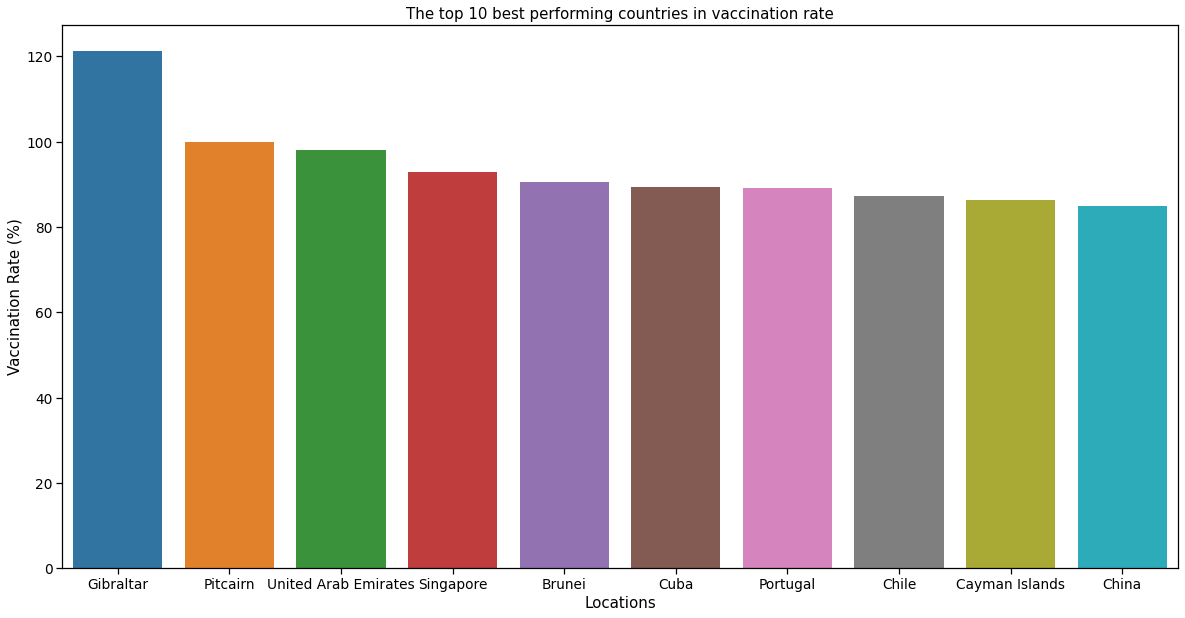

In [17]:
# Grouping the data by country and then sorting the data by the max value from highest to lowest

top_percent = check_df.groupby('location').people_vaccinated_per_hundred.max().sort_values(ascending=False)
top_percent_f = top_percent.dropna(axis='rows').reset_index()

display(top_percent_f[0:10])

# Plotting the data
with sns.plotting_context('notebook', font_scale = 1.25):
    plt.figure(figsize=(20, 10))
    plt.title('The top 10 best performing countries in vaccination rate')
    sns.barplot(x=top_percent_f.location[0:10], y=top_percent_f.people_vaccinated_per_hundred[0:10])
    plt.xlabel('Locations')
    plt.ylabel('Vaccination Rate (%)');

Gibraltar is not looked at since it does not make sense to have more than 100% vaccination rate. 

It seems that small countries such as Pitcairn and really wealthy countires such as UAE and Singapore have very high vacciantion rates.

**Part 3 - Model selection and fitting to the data**

In [18]:
#Create new columns based on distinct values and count them
df = df.sort_values('location')
df['eid'] = (df.groupby(['location']).cumcount()==0).astype(int)
df['eid'] = df['eid'].cumsum()
can_df=df.loc[df['eid'] == 38] #38 for Canada and 223 for US

#check dataframe of Canada
can_sndf = can_df.sort_values('people_vaccinated_per_hundred')
can_sndf

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,eid
9796,Canada,CAN,2020-12-15,727.0,727.0,0.0,0.0,722.0,722.0,0.00,0.00,0.00,0.00,19.0,722.0,0.002,38
9795,Canada,CAN,2020-12-14,5.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,38
9797,Canada,CAN,2020-12-16,3016.0,3016.0,0.0,0.0,2289.0,1506.0,0.01,0.01,0.00,0.00,40.0,1506.0,0.004,38
9798,Canada,CAN,2020-12-17,7267.0,7267.0,0.0,0.0,4251.0,2421.0,0.02,0.02,0.00,0.00,64.0,2421.0,0.006,38
9801,Canada,CAN,2020-12-20,12901.0,12901.0,0.0,0.0,859.0,2149.0,0.03,0.03,0.00,0.00,56.0,2149.0,0.006,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10133,Canada,CAN,2021-11-17,59776509.0,30102545.0,28764923.0,909041.0,76112.0,61164.0,157.03,79.08,75.56,2.39,1607.0,14376.0,0.038,38
10134,Canada,CAN,2021-11-18,59852559.0,30121803.0,28795770.0,934986.0,76050.0,66659.0,157.23,79.13,75.64,2.46,1751.0,15696.0,0.041,38
10135,Canada,CAN,2021-11-19,59918117.0,30136287.0,28821607.0,960223.0,65558.0,62649.0,157.40,79.16,75.71,2.52,1646.0,14717.0,0.039,38
10136,Canada,CAN,2021-11-20,59947684.0,30145291.0,28837538.0,964855.0,29567.0,62168.0,157.48,79.19,75.75,2.53,1633.0,14706.0,0.039,38


In [19]:
#Get the values from the column where vaccination rate of Canada (or country of your choice) is stored.
can_val = can_sndf['people_vaccinated_per_hundred'].values

In [20]:
us_df=df.loc[df['eid'] == 223] #223 - United States

#check dataframe of Canada
us_sndf = us_df.sort_values('people_vaccinated_per_hundred')
us_sndf

us_val = us_sndf['people_vaccinated_per_hundred'].values

ARIMA Model will be used to help predict the COVID-19 Vaccination rates in the nexxt 50 days by allowing us to easily analyze the time series of the current vaccination rates. 

**Manual Check using ARIMA Model**

We want the time series stationary to make it not depend on the time at which the series is analyzed. To make a non-stationary time series to stationary, we use differencing operation for stabilizing the mean of the series where we calculate the differences in a back to back manner. This helps in removing (or minimizing) trend and seasonality.

Sometimes first order differencing of time series may not remove all the trend and seasonality and and it is required to difference the data one more time (second order differencing of time series) to get a stationary time series.

After analyzing Autocorrelation plot, a second order differencing is applied to make the time series stationary.

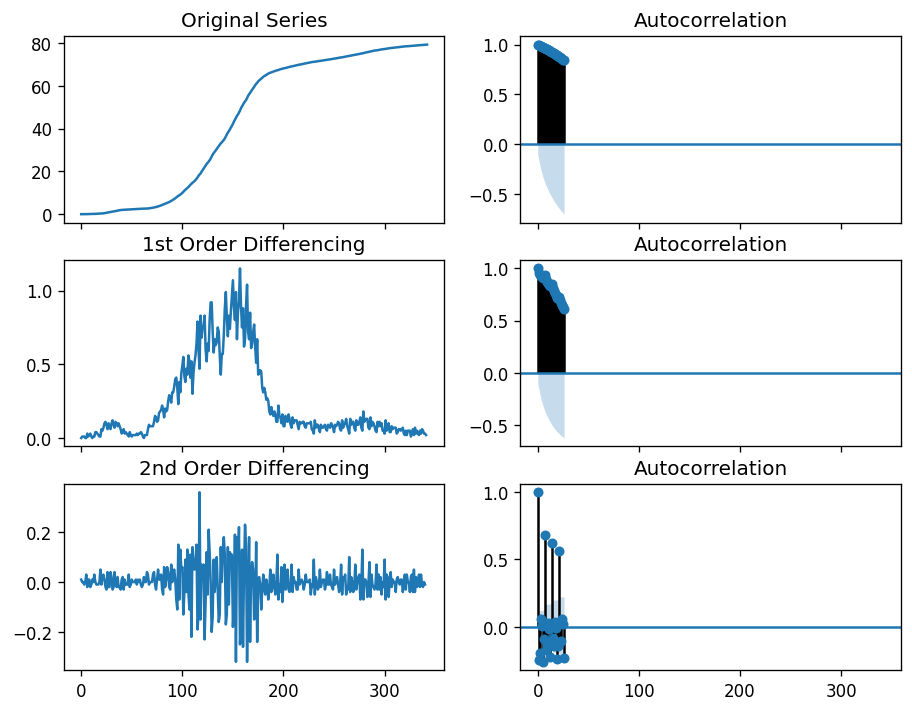

In [21]:
# Canada stationary time series

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(can_val); axes[0, 0].set_title('Original Series')
plot_acf(can_val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(can_val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(can_val), ax=axes[1, 1])
diffval = np.diff(can_val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
plt.show()

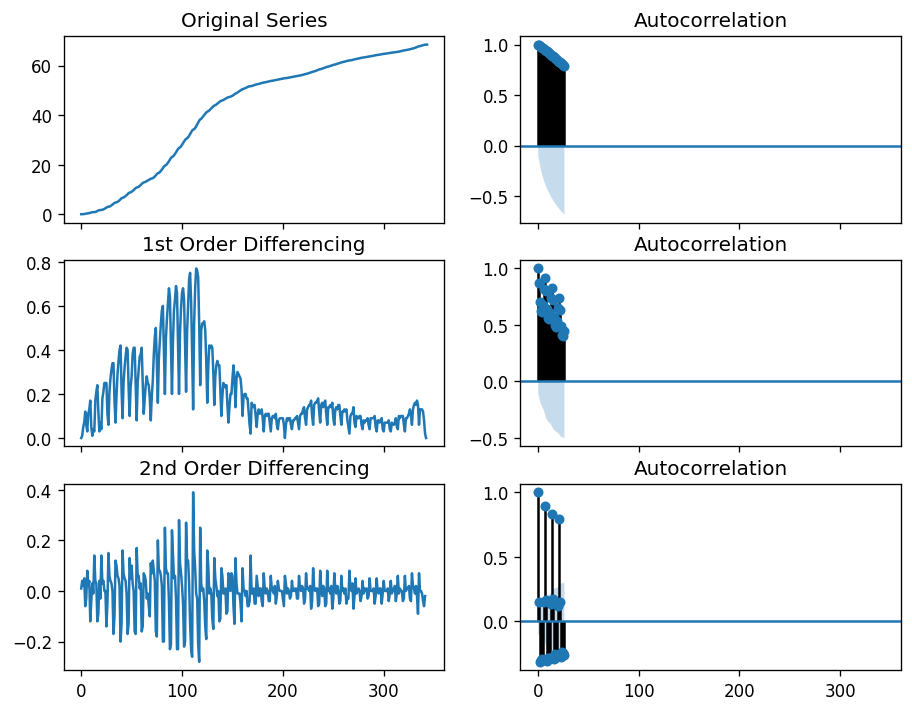

In [22]:
# United States stationary time series

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(us_val); axes[0, 0].set_title('Original Series')
plot_acf(us_val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(us_val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(us_val), ax=axes[1, 1])
diffval = np.diff(us_val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
plt.show()

From the second order differencing autocoorelation, we can see that most of the points fits within the light shaded region which means that our model is stationary. 

An ARIMA model without seasonality is represented as ARIMA(p,d,q), p is the count of AR terms, d is the count of differences needed (in this example, we see that d=2 is needed)to make the time series as a stationary one and q is the count of MA terms. Then we are finding the best ARIMA model to fit. Akaike’s Information Criterion (AIC), is observed here to identify the order of the best ARIMA model. The lowest AIC value represents the best model.

To find the optimal value of differencing (we assumed d=2 previously by plotting the time series), we can use Augmented Dickey–Fuller (ADF) test.

In [23]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 39.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [24]:
# Canada - Applying autoARIMA to find the best parameters instead of doing it manually

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(can_val, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-104.728, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3713.639, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-805.313, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-818.800, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-338.133, Time=0.90 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.55 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-425.183, Time=1.44 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-810.121, Time=1.95 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-817.783, Time=2.01 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 1

Canada Data - the best ARIMA model has the parameters of (3, 0, 2), this is qweird since from manually calculating the d-value we see that we need at least a second order differencing. 

In [25]:
# United States - Applying autoARIMA to find the best parameters instead of doing it manually

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
us_model = pm.auto_arima(us_val, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(us_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-748.796, Time=0.69 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-711.986, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-717.905, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-727.220, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-713.986, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-846.815, Time=1.12 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-759.470, Time=0.36 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-855.893, Time=2.41 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-773.471, Time=0.91 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.64 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-938.226, Time=2.49 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-884.927, Time=3.34 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-821.473, Time=3.42 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-

US Data - the best ARIMA model has the parameters of (2, 2, 3)

Using Auto ARIMA to calculate the best parameters to minimize AIC

In [26]:
stepwise_fit = pm.auto_arima(can_val, trace = True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-829.925, Time=0.70 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-776.375, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-796.401, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-819.566, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-831.934, Time=0.44 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-833.339, Time=0.22 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-831.975, Time=0.70 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-829.548, Time=0.35 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-836.736, Time=0.69 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-883.693, Time=0.69 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-892.442, Time=0.81 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-834.851, Time=0.54 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=-898.571, Time=0.85 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-831.303, Time=0.60 sec
 ARIMA(5,2,3)(0,0,0)[0]          

The best model chosen for Canada data is : ARIMA (p,d,q) = ARIMA(5,2,2).

As we assumed, second order differencing has to be performed for making the time series stationary in this scenario.

As the next step, we perform diagnostic check for the residual as given below:

In [27]:
us_stepwise_fit = pm.auto_arima(us_val, trace = True, suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-944.334, Time=0.54 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-713.986, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-719.905, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-729.220, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-848.809, Time=0.21 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-851.386, Time=1.20 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-970.357, Time=0.58 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-848.580, Time=0.52 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-957.335, Time=0.65 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=-895.886, Time=1.18 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=-892.543, Time=0.75 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=-1001.804, Time=0.93 sec
 ARIMA(4,2,4)(0,0,0)[0]             : AIC=-1111.288, Time=0.97 sec
 ARIMA(4,2,3)(0,0,0)[0]             

The best model chosen for US data is : ARIMA (p,d,q) = ARIMA(5,2,4).

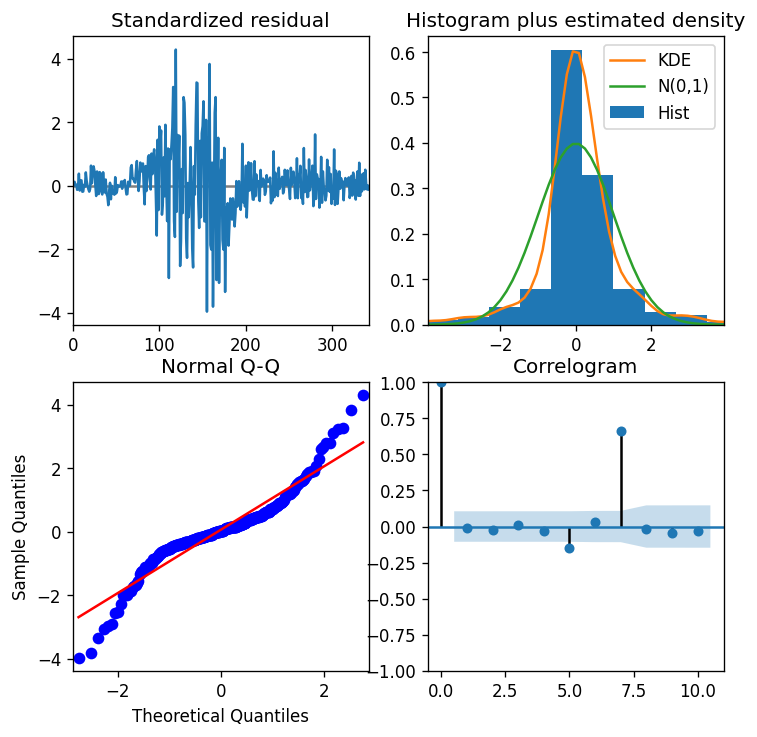

In [28]:
model.plot_diagnostics(figsize=(7,7))
plt.show()

So the residuals are stationary (white noise in top-left) our data looks pretty noisy however. The data is normally distributed with zero mean (shown on the top right graph), and are uncorrelated with lagged versions of itself for the most part.

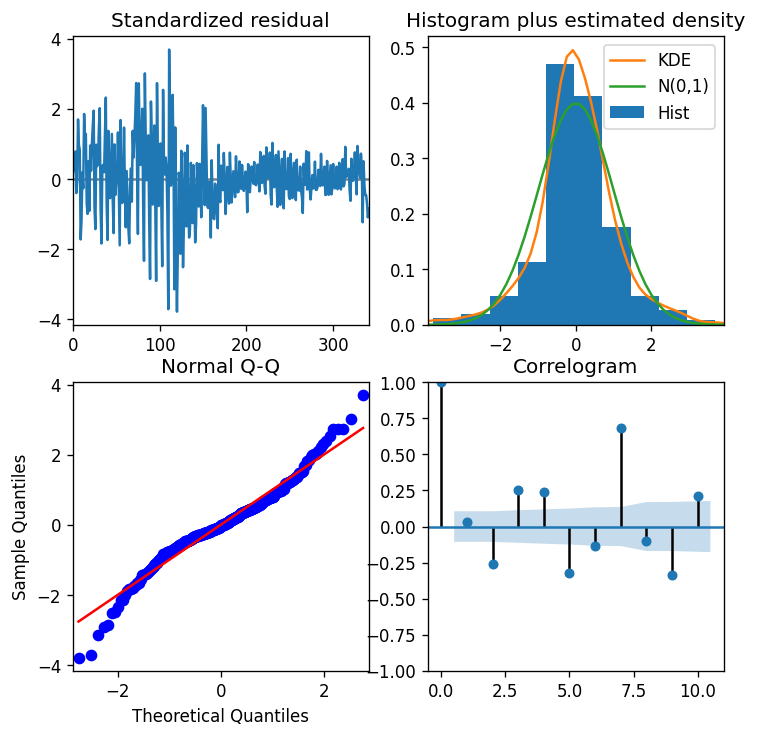

In [29]:
us_model.plot_diagnostics(figsize=(7,7))
plt.show()

So the residuals are stationary (white noise in top-left) our data looks extremely noisy however. The data is normally distributed with zero mean (shown on the top right graph), however, it looks correlated with lagged versions of itself since most of the points are outside of the light blue shaded region.

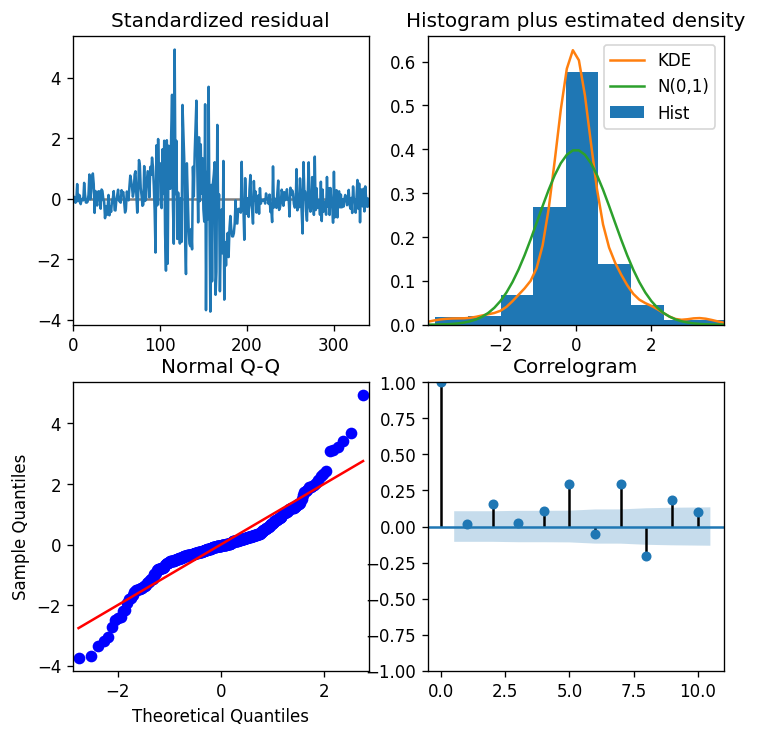

In [30]:
stepwise_fit.plot_diagnostics(figsize=(7,7))
plt.show()

Using Auto ARIMA, it seems that for the Canadian data, more points become more coorelated together (outside the light blue shaded region)

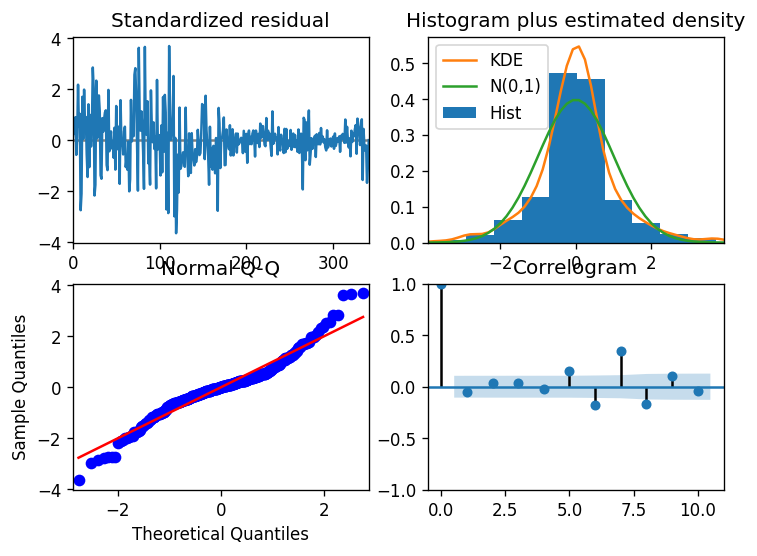

In [31]:
us_stepwise_fit.plot_diagnostics(figsize=(7,5))
plt.show()

Using Auto ARIMA, it seems that for the US data, more points become less coorelated together (inside the light blue shaded region)

Since Auto ARIMA models provide us the lower AIC values, we will use those models as our forecast. 

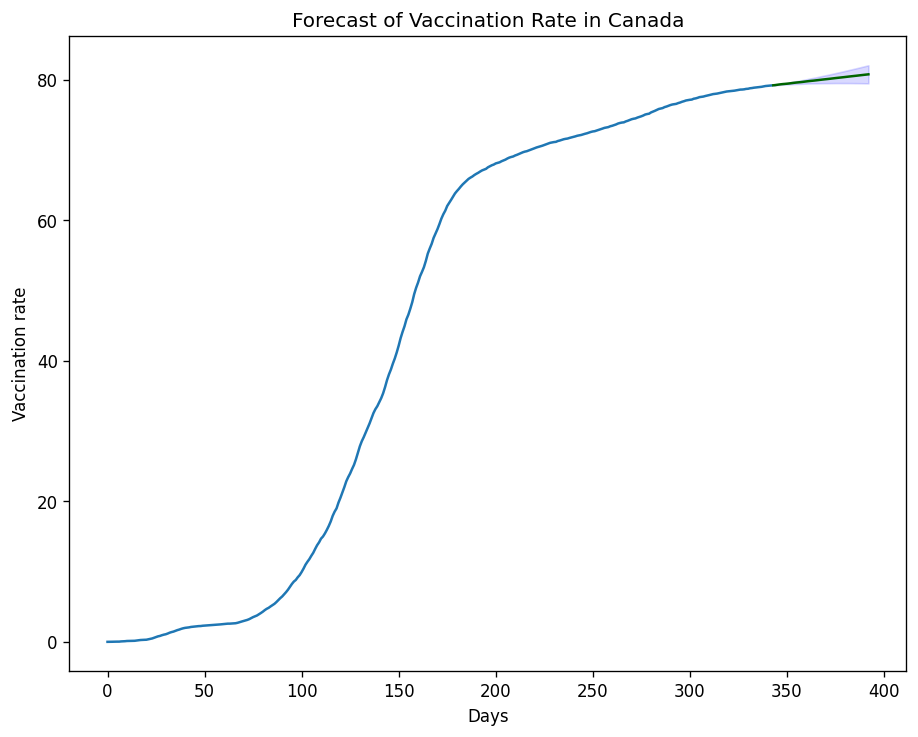

In [32]:
# Vaccination Rate Forecast for Canada
n_periods = 50
fc, confint = stepwise_fit.predict(n_periods=n_periods, return_conf_int=True, alpha=0.80) # Model is used to predict future values with Confidence Intervals
# Alpha of 0.8 was chosen since for the worst case scenario, it does not make sense for the vaccination rate to decrease so we need to pick alpha where it does not decrease
# Technically the population can increase with no one getting vaccinated, thereby decreasing the vaccination rate, but this dataset assumes constant population and that rate is very unlikely

index_of_fc = np.arange(len(can_val), len(can_val)+n_periods) # Adding the extra 50 days

# Make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc) # Base case
lower_series = pd.Series(confint[:, 0], index=index_of_fc) # Worst Case scenario
upper_series = pd.Series(confint[:, 1], index=index_of_fc) # Best case scenario

# Plot
plt.plot(can_val)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of Vaccination Rate in Canada")
plt.xlabel("Days")
plt.ylabel("Vaccination rate")
plt.show()

In [33]:
fc[-1] # Vaccination rate after 50 days

80.79287094061569

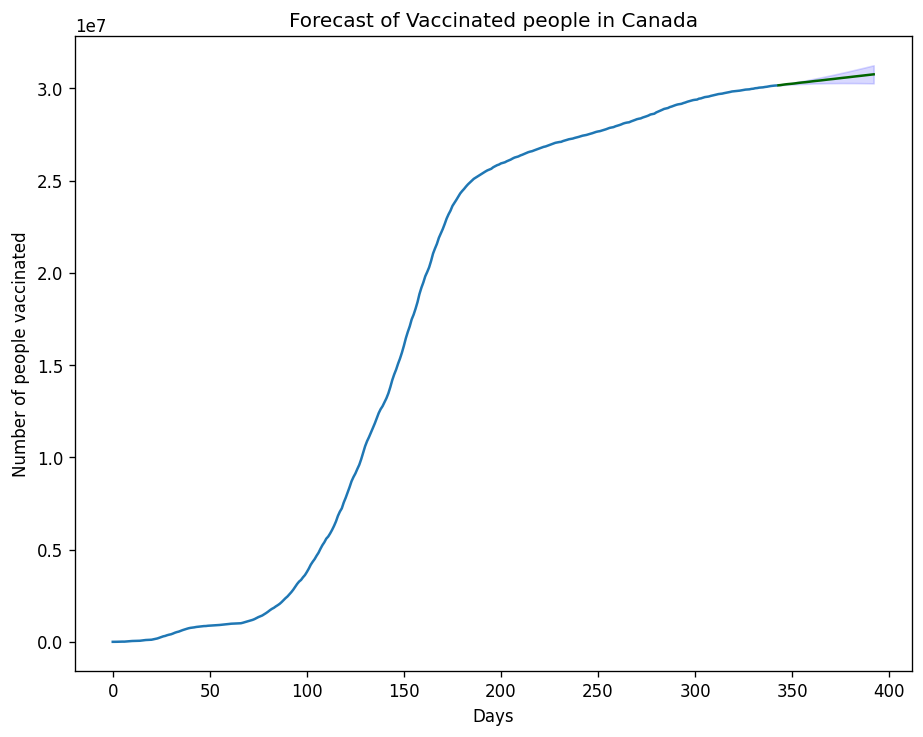

In [34]:
# Population of Canada is: 38066161 (From the df table)

# People Vaccinated Forecast for Canada
n_periods = 50
fc, confint = stepwise_fit.predict(n_periods=n_periods, return_conf_int=True, alpha=0.80) # Model is used to predict future values with Confidence Intervals
# Alpha of 0.8 was chosen since for the worst case scenario, it does not make sense for the amount of people vaccinated to decrease so we need to pick alpha where it does not decrease

index_of_fc = np.arange(len(can_val), len(can_val)+n_periods) # Adding the extra 50 days

fc = 38066161 * fc / 100
confint = 38066161 * confint / 100

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc) # Base Model
lower_series = pd.Series(confint[:, 0], index=index_of_fc) # Worst Case scenario
upper_series = pd.Series(confint[:, 1], index=index_of_fc) # Best Case scenario

can_val_vac = can_sndf['people_vaccinated'].values

# Plot
plt.plot(can_val_vac)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of Vaccinated people in Canada")
plt.xlabel("Days")
plt.ylabel("Number of people vaccinated")
plt.show()

In [35]:
print(fc[-1])
print(fc[0])
print(fc[-1] - can_val_vac[-1])

30754744.328776978
30160750.501877103
602538.328776978


From our base case model, we can predict that 30,770,417 people will be vaccinated in Canada by the end of the next 50 days (from the last day of the dataset). This means 618,211 more people will be vaccinated.

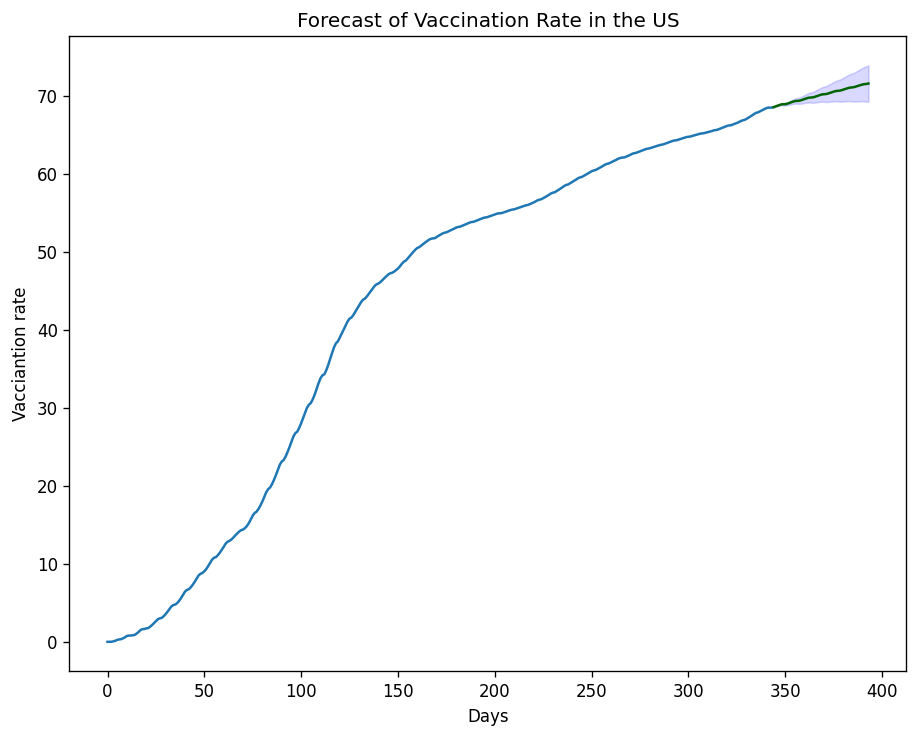

In [36]:
# Vaccination Rate Forecast for United States

n_periods = 50
fc, confint = us_stepwise_fit.predict(n_periods=n_periods, return_conf_int=True, alpha=0.60) # Model is used to predict future values with Confidence Intervals
# Alpha of 0.8 was chosen since for the worst case scenario, it does not make sense for the vaccination rate to decrease so we need to pick alpha where it does not decrease
# Technically the population can increase with no one getting vaccinated, thereby decreasing the vaccination rate, but this dataset assumes constant population and that rate is very unlikely

index_of_fc = np.arange(len(us_val), len(us_val)+n_periods) # Adding the extra 50 days

# Make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc) # Base Model
lower_series = pd.Series(confint[:, 0], index=index_of_fc) # Worst Case scenario
upper_series = pd.Series(confint[:, 1], index=index_of_fc) # Best Case scenario

# Plot
plt.plot(us_val)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of Vaccination Rate in the US")
plt.xlabel("Days")
plt.ylabel("Vacciantion rate")
plt.show()

In [37]:
fc[-1] # Vaccination Rate after 50 days

71.56593358109822

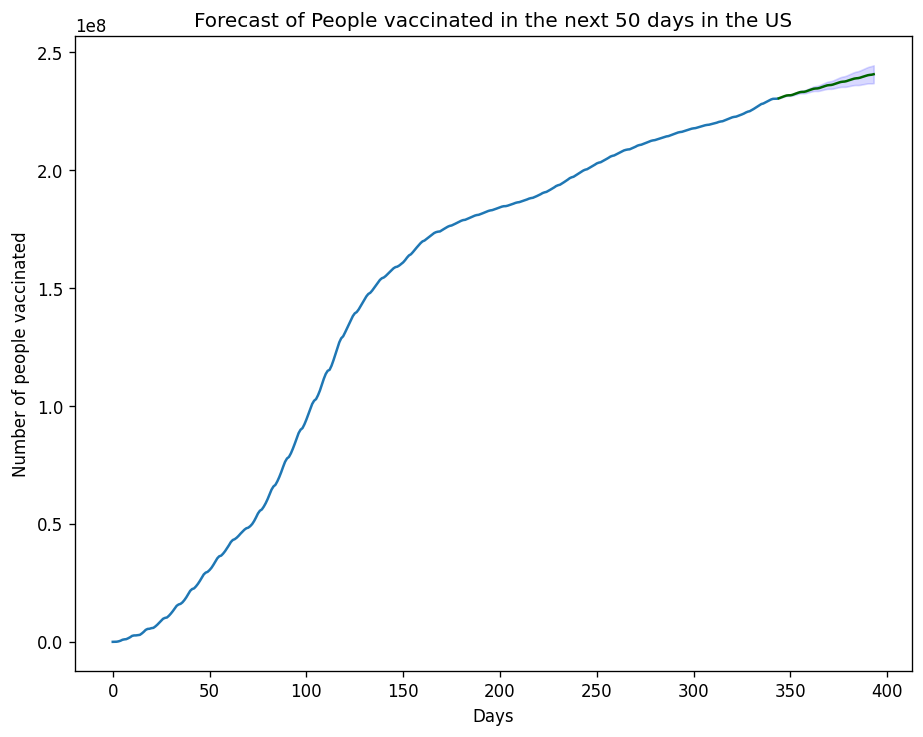

In [38]:
# Population of United States is: 336300736 (From the df table)

# Forecast
n_periods = 50
fc, confint = us_stepwise_fit.predict(n_periods=n_periods, return_conf_int=True, alpha=0.80) # Model is used to predict future values with Confidence Intervals
# Alpha of 0.8 was chosen since for the worst case scenario, it does not make sense for the amount of people vaccinated to decrease so we need to pick alpha where it does not decrease

index_of_fc = np.arange(len(us_val), len(us_val)+n_periods) # Adding the extra 50 days
 
fc = 336300736  * fc / 100
confint = 336300736  * confint / 100

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc) # Base Model
lower_series = pd.Series(confint[:, 0], index=index_of_fc) # Worst Case scenario
upper_series = pd.Series(confint[:, 1], index=index_of_fc) # Best Case scenario

us_val_vac = us_sndf['people_vaccinated'].values

# Plot
plt.plot(us_val_vac)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of People vaccinated in the next 50 days in the US")
plt.xlabel("Days")
plt.ylabel("Number of people vaccinated")
plt.show()

In [39]:
print(fc[-1])
print(fc[0])
print(fc[-1] - us_val_vac[-1])

240676761.35850447
230464789.4883918
10378017.358504474


From our base case model, we can predict that 240,826,270 people will be vaccinated in the US by the end of the next 50 days (from the last day of the dataset). This means 10,527,526 more people will be vaccinated.

There may be many factors or features affecting the vaccination rate in a country. This simple time series analysis by ARIMA forecasting equation is only considering a linear relationship between the days and vaccination rate in which the predictors comprised of lags of the dependent feature (here vaccination rate) and lags of the forecasting errors.

**Part 4 - Relating COVID-19 Vaccination Rates to a Second Dataset - Canada**

In [40]:
# We will perform linear correlation b/w 2 features to see if they're dependent on each other
uploader = files.upload()

# loading the dataset 
df_2 = pd.read_csv(io.BytesIO(uploader['Complete_covid19_dataset.csv']))
print('Shape of data',df.shape)
#see the first five of our dataframe
df_2.head()

Saving Complete_covid19_dataset.csv to Complete_covid19_dataset.csv
Shape of data (35729, 17)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [41]:
df_2.isna().sum()

iso_code                                        0
continent                                    8578
location                                        0
date                                            0
total_cases                                  7393
                                            ...  
human_development_index                     18176
excess_mortality_cumulative_absolute       129736
excess_mortality_cumulative                129736
excess_mortality                           129736
excess_mortality_cumulative_per_million    129736
Length: 67, dtype: int64

In [42]:
#Create new columns based on distinct values and count them
df_2 = df_2.sort_values('location')
df_2['eid'] = (df_2.groupby(['location']).cumcount()==0).astype(int)
df_2['eid'] = df_2['eid'].cumsum()

# Create new df for Canada 
can_df_2=df_2.loc[df_2['eid'] == 38] #38 and 223

#check dataframe of Canada
can_sndf_2 = can_df_2.sort_values('people_vaccinated_per_hundred')
can_sndf_2

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,eid
21633,CAN,North America,Canada,2020-12-14,474661.0,8645.0,6658.143,13677.0,140.0,111.571,12468.795,227.094,174.902,359.279,3.678,2.931,1.05,685.0,17.994,3335.0,87.607,NaN,NaN,NaN,NaN,131408.0,16008664.0,420.529,3.452,126618.0,3.326,0.053,19.0,tests performed,5.0,5.0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21634,CAN,North America,Canada,2020-12-15,480952.0,6291.0,6661.714,13793.0,116.0,114.286,12634.052,165.257,174.996,362.326,3.047,3.002,1.04,704.0,18.493,3499.0,91.915,NaN,NaN,NaN,NaN,123736.0,16132400.0,423.779,3.250,128820.0,3.384,0.052,19.3,tests performed,727.0,727.0,NaN,NaN,722.0,722.0,0.00,0.00,NaN,NaN,19.0,722.0,0.002,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21635,CAN,North America,Canada,2020-12-16,487685.0,6733.0,6706.857,13911.0,118.0,114.571,12810.920,176.868,176.181,365.426,3.100,3.010,1.04,720.0,18.914,3549.0,93.228,NaN,NaN,NaN,NaN,96979.0,16229379.0,426.327,2.548,128724.0,3.381,0.052,19.2,tests performed,3016.0,3016.0,NaN,NaN,2289.0,1506.0,0.01,0.01,NaN,NaN,40.0,1506.0,0.004,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21636,CAN,North America,Canada,2020-12-17,495152.0,7467.0,6830.143,14067.0,156.0,120.000,13007.070,196.149,179.420,369.524,4.098,3.152,1.04,720.0,18.914,3556.0,93.412,NaN,NaN,NaN,NaN,127245.0,16356624.0,429.670,3.343,129656.0,3.406,0.053,19.0,tests performed,7267.0,7267.0,NaN,NaN,4251.0,2421.0,0.02,0.02,NaN,NaN,64.0,2421.0,0.006,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21639,CAN,North America,Canada,2020-12-20,514500.0,5826.0,6926.286,14374.0,90.0,119.571,13515.319,153.042,181.946,377.588,2.364,3.141,1.02,735.0,19.308,3506.0,92.099,NaN,NaN,NaN,NaN,142846.0,16783349.0,440.879,3.752,129442.0,3.400,0.054,18.7,tests performed,12901.0,12901.0,NaN,NaN,859.0,2149.0,0.03,0.03,NaN,NaN,56.0,2149.0,0.006,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,13955.0,4.90,9.43,366.581693,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21531,CAN,North America,Canada,2020-09-03,132582.0,626.0,553.714,9205.0,6.0,5.286,34

In [43]:
# Drop NAN values for total vaccinations since that's a key feature required

can_sndf_2 = can_sndf_2.drop(can_sndf_2[can_sndf_2.total_vaccinations.isna()].index)
can_sndf_2

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,eid
21633,CAN,North America,Canada,2020-12-14,474661.0,8645.0,6658.143,13677.0,140.0,111.571,12468.795,227.094,174.902,359.279,3.678,2.931,1.05,685.0,17.994,3335.0,87.607,NaN,NaN,NaN,NaN,131408.0,16008664.0,420.529,3.452,126618.0,3.326,0.053,19.0,tests performed,5.0,5.0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21634,CAN,North America,Canada,2020-12-15,480952.0,6291.0,6661.714,13793.0,116.0,114.286,12634.052,165.257,174.996,362.326,3.047,3.002,1.04,704.0,18.493,3499.0,91.915,NaN,NaN,NaN,NaN,123736.0,16132400.0,423.779,3.250,128820.0,3.384,0.052,19.3,tests performed,727.0,727.0,NaN,NaN,722.0,722.0,0.00,0.00,NaN,NaN,19.0,722.0,0.002,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21635,CAN,North America,Canada,2020-12-16,487685.0,6733.0,6706.857,13911.0,118.0,114.571,12810.920,176.868,176.181,365.426,3.100,3.010,1.04,720.0,18.914,3549.0,93.228,NaN,NaN,NaN,NaN,96979.0,16229379.0,426.327,2.548,128724.0,3.381,0.052,19.2,tests performed,3016.0,3016.0,NaN,NaN,2289.0,1506.0,0.01,0.01,NaN,NaN,40.0,1506.0,0.004,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21636,CAN,North America,Canada,2020-12-17,495152.0,7467.0,6830.143,14067.0,156.0,120.000,13007.070,196.149,179.420,369.524,4.098,3.152,1.04,720.0,18.914,3556.0,93.412,NaN,NaN,NaN,NaN,127245.0,16356624.0,429.670,3.343,129656.0,3.406,0.053,19.0,tests performed,7267.0,7267.0,NaN,NaN,4251.0,2421.0,0.02,0.02,NaN,NaN,64.0,2421.0,0.006,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21639,CAN,North America,Canada,2020-12-20,514500.0,5826.0,6926.286,14374.0,90.0,119.571,13515.319,153.042,181.946,377.588,2.364,3.141,1.02,735.0,19.308,3506.0,92.099,NaN,NaN,NaN,NaN,142846.0,16783349.0,440.879,3.752,129442.0,3.400,0.054,18.7,tests performed,12901.0,12901.0,NaN,NaN,859.0,2149.0,0.03,0.03,NaN,NaN,56.0,2149.0,0.006,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,13955.0,4.9,9.43,366.581693,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21969,CAN,North America,Canada,2021-11-15,1760822.0,4370.0,2497.714,29435.0,50.0,27.0

In [44]:
# Reduce the columns to features we will examine - we will examine both icu_patients and total_deaths related to covid-19

can_sndf_2_red = can_sndf_2[['location', 'date', 'total_deaths', 'icu_patients', 'people_vaccinated', 'people_vaccinated_per_hundred']]
can_sndf_2_red

,location,date,total_deaths,icu_patients,people_vaccinated,people_vaccinated_per_hundred
21633,Canada,2020-12-14,13677.0,685.0,5.0,0.00
21634,Canada,2020-12-15,13793.0,704.0,727.0,0.00
21635,Canada,2020-12-16,13911.0,720.0,3016.0,0.01
21636,Canada,2020-12-17,14067.0,720.0,7267.0,0.02
21639,Canada,2020-12-20,14374.0,735.0,12901.0,0.03
...,...,...,...,...,...,...
21969,Canada,2021-11-15,29435.0,496.0,30069875.0,78.99
21970,Canada,2021-11-16,29458.0,486.0,30082576.0,79.02
21971,Canada,2021-11-17,29485.0,484.0,30102545.0,79.08
21972,Canada,2021-11-18,29516.0,468.0,30121803.0,79.13


In [45]:
# Check how many NAN values needs to be filled

can_sndf_2_red.isna().sum()

location                         0
date                             0
total_deaths                     0
icu_patients                     1
people_vaccinated                0
people_vaccinated_per_hundred    0
dtype: int64

In [46]:
# NAN value in the last value of icu_patients, will replace it with the previous' day value

can_sndf_2_red.icu_patients.fillna(method='ffill', inplace=True)
can_sndf_2_red

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,location,date,total_deaths,icu_patients,people_vaccinated,people_vaccinated_per_hundred
21633,Canada,2020-12-14,13677.0,685.0,5.0,0.00
21634,Canada,2020-12-15,13793.0,704.0,727.0,0.00
21635,Canada,2020-12-16,13911.0,720.0,3016.0,0.01
21636,Canada,2020-12-17,14067.0,720.0,7267.0,0.02
21639,Canada,2020-12-20,14374.0,735.0,12901.0,0.03
...,...,...,...,...,...,...
21969,Canada,2021-11-15,29435.0,496.0,30069875.0,78.99
21970,Canada,2021-11-16,29458.0,486.0,30082576.0,79.02
21971,Canada,2021-11-17,29485.0,484.0,30102545.0,79.08
21972,Canada,2021-11-18,29516.0,468.0,30121803.0,79.13


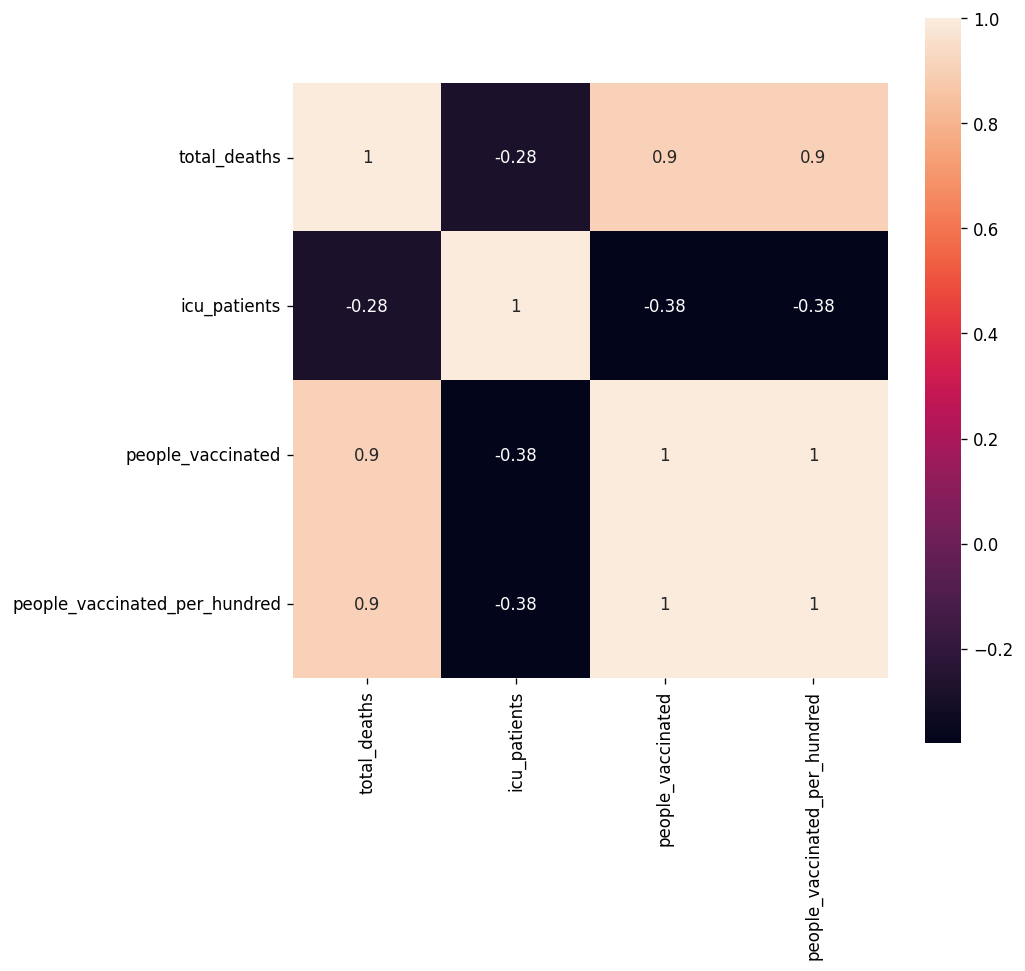

In [47]:
# Correlation matrix between the features

plt.subplots(figsize=(8, 8))
sns.heatmap(can_sndf_2_red.corr(), annot=True, square=True)
plt.show()

In [48]:
# Creating arrays for people vaccinated, amount of deaths, and amount of icu patients

death = can_sndf_2_red['total_deaths'].values
vac = can_sndf_2_red['people_vaccinated'].values
icu = can_sndf_2_red['icu_patients'].values

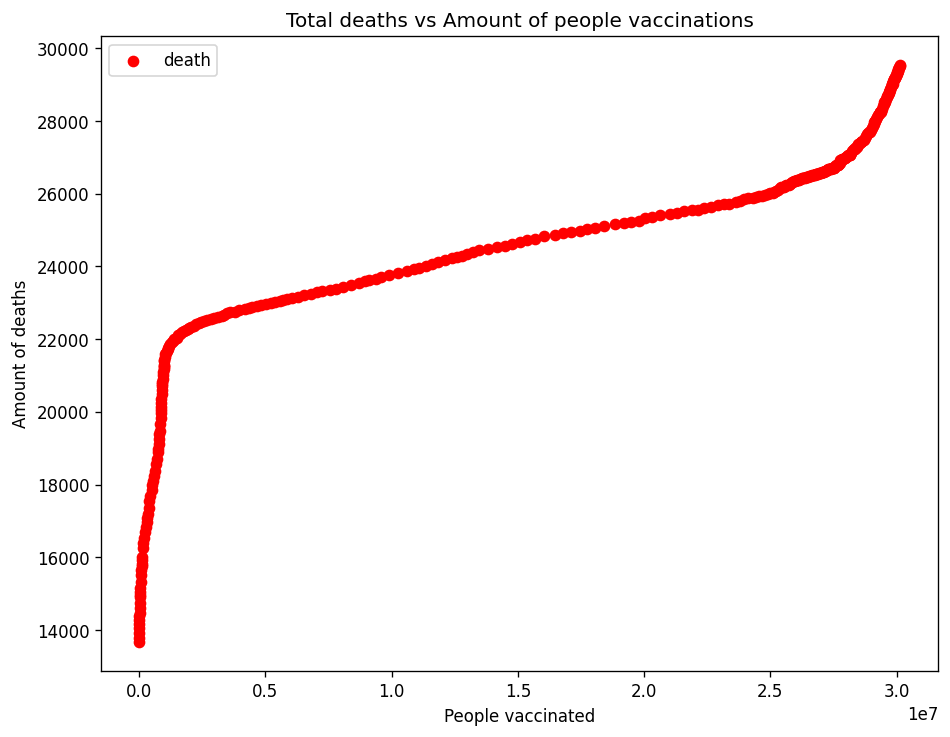

In [49]:
plt.scatter(vac, death, c='r', label='death')
plt.xlabel('People vaccinated')
plt.ylabel('Amount of deaths')
plt.title('Total deaths vs Amount of people vaccinations')
plt.legend()
plt.show()

From this graph we can see that before the vaccine came out, there were many deaths related to covid. This is due to the fact that it took a while for the vaccine rollout to occur. As vaccines prograssively came out, the rate of deaths decreased, we can see the slope of deaths decreasing. Lastly, the slope of deaths is exponentially increasing as of now, this may be due to the fact that new varients are out along with less strict lockdown regulations causing the vaccine to lose its effectiveness. 

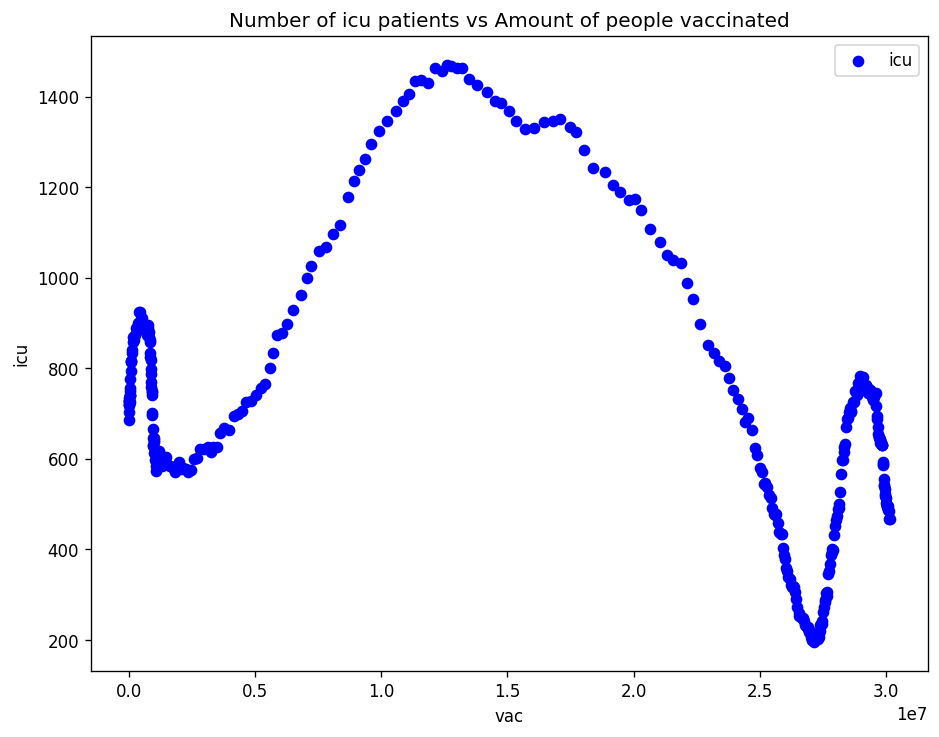

In [50]:
plt.scatter(vac, icu, c='b', label='icu')
plt.xlabel('vac')
plt.ylabel('icu')
plt.title('Number of icu patients vs Amount of people vaccinated')
plt.legend()
plt.show()

From this graph we can see that before the vaccine came out, there were many people placed into icu treatments. Even as the vaccines began to rollout,
the number of icu patients increased until a large majority of Canadians got the vaccines. We see the number of icu patients decrease when most Canadians are vaccinated but now it's start to increase. This may be due to new varients along with less strict lockdown regulations causing the vaccine to lose its effectiveness as well.

In [51]:
# Normalize values

norm = np.linalg.norm(death)
normal_death = death/norm

norm = np.linalg.norm(vac)
normal_vac = vac/norm

norm = np.linalg.norm(icu)
normal_icu = icu/norm

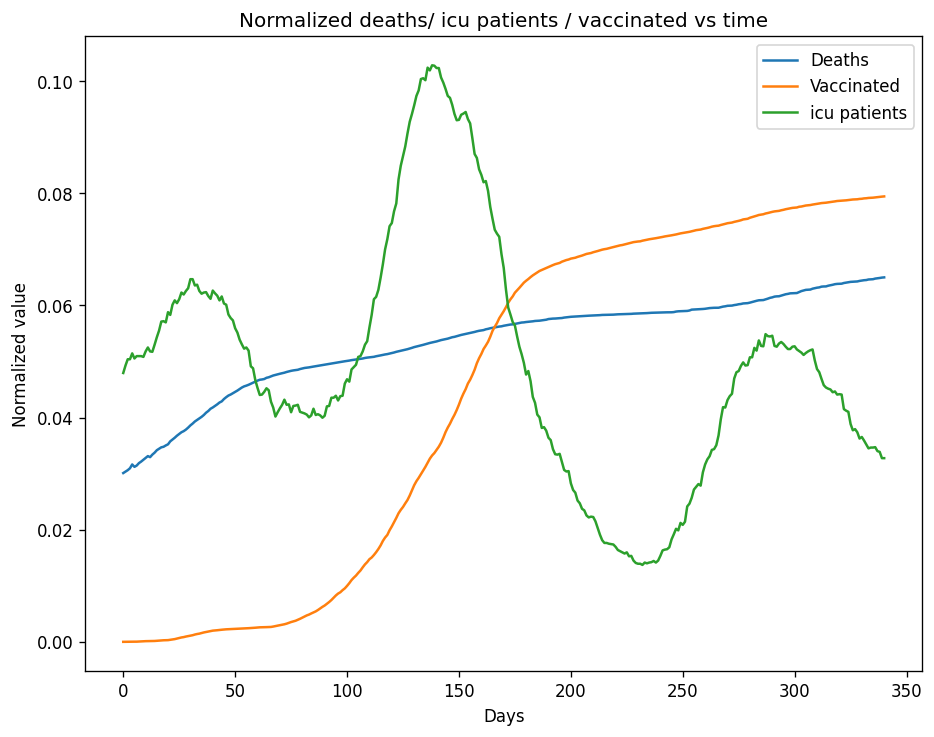

In [52]:
# Plot normalized values against time
plt.plot(normal_death, label = 'Deaths')
plt.plot(normal_vac, label = 'Vaccinated')
plt.plot(normal_icu, label = 'icu patients')
plt.xlabel('Days')
plt.ylabel('Normalized value')
plt.legend()

plt.title("Normalized deaths/ icu patients / vaccinated vs time")
plt.show()

We can see that the rate of people getting vaccinated in Canada is slowing down, the amount of deaths is somewhat linear, and the number of icu patients is decreasing.  

In [53]:
# Perform t-test to show the relationship between amount of people vaccinated and total deaths and icu patients

from scipy.stats import ttest_ind

print(ttest_ind(vac, death))
ttest_ind(vac, icu)

Ttest_indResult(statistic=25.437029129114666, pvalue=8.18517994172982e-101)


Ttest_indResult(statistic=25.473141285831804, pvalue=5.1084460523592485e-101)

Since P-values are essentially 0, this means that the features are  statistically significant (the differences between your groups are significant).

In [54]:
# Will use vaccination rate to predict amount of deaths and icu patients in the next 50 days

can_val = can_sndf_2_red['people_vaccinated_per_hundred'].values
fc, confint = stepwise_fit.predict(n_periods=n_periods, return_conf_int=True, alpha=0.80)

In [55]:
# Estimating deaths using linear regression
from sklearn import linear_model

X = can_val.reshape(-1, 1)
y = death.reshape(-1, 1)
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

fc = fc.reshape(-1, 1)
# # now assuming some new set of data with the same columns as your training data 
death_predictions = regr.predict(fc)

In [56]:
# Estimating icu patients using linear regression
from sklearn import linear_model

X = can_val.reshape(-1, 1)
y = icu.reshape(-1, 1)
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

fc = fc.reshape(-1, 1)
# # now assuming some new set of data with the same columns as your training data 
icu_predictions = regr.predict(fc)

Text(0.5, 1.0, 'Forcasted amount of deaths')

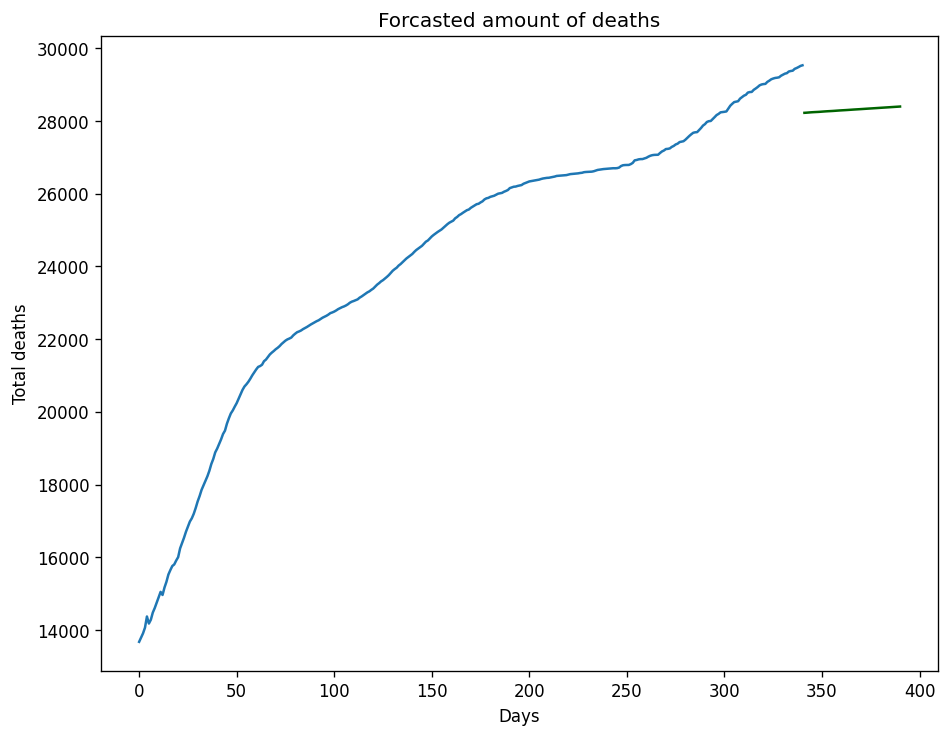

In [57]:
# Plotting forecasted amount of deaths

index_of_fc = np.arange(len(X), len(X)+n_periods)

death_predictions = death_predictions.flatten()

death_series = pd.Series(death_predictions, index=index_of_fc)

plt.plot(death)
plt.xlabel('Days')
plt.ylabel('Total deaths')
plt.plot(death_series, color='darkgreen')
plt.title("Forcasted amount of deaths")

This model doesn't make sense since we see the forecasted number of deaths lower than the last recorded amount of deaths. This model can be fine-tuned by using a different regression model. We can also add such that the first value should coincide with the last recorded amount of deaths.

Text(0.5, 1.0, 'Forcasted amount of icu patients')

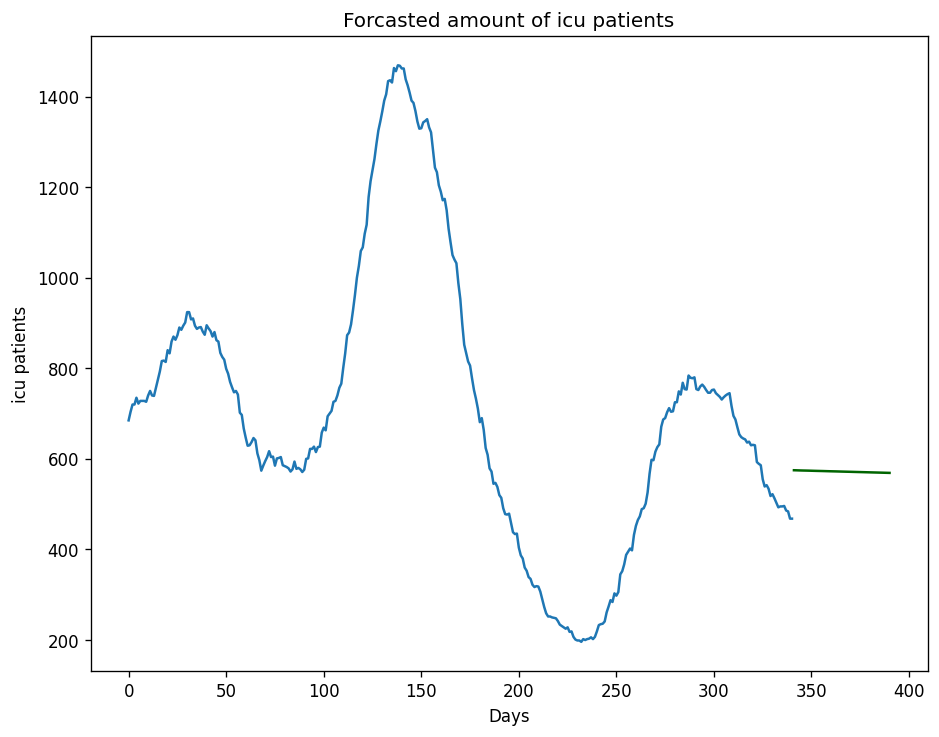

In [58]:
# Plotting forecasted amount of icu patients
index_of_fc = np.arange(len(X), len(X)+n_periods)

icu_predictions = icu_predictions.flatten()

icu_series = pd.Series(icu_predictions, index=index_of_fc)

plt.plot(icu)
plt.xlabel('Days')
plt.ylabel('icu patients')
plt.plot(icu_series, color='darkgreen')
plt.title("Forcasted amount of icu patients")

We can see that the forcasted amount of icu patients is higher. This model can be fine-tuned by using a different regression model since we can see that the trend doesn't seem to follow a linear model. 

**Part 4 - Relating COVID-19 Vaccination to a Second Dataset - US Data**

In [59]:
us_df_2=df_2.loc[df_2['eid'] == 225] #225 is United States

# Create new dataframe of US
us_sndf_2 = us_df_2.sort_values('people_vaccinated_per_hundred')
us_sndf_2

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,eid
127219,USA,North America,United States,2020-12-14,16672597.0,200631.0,219503.000,305114.0,1649.0,2567.429,50080.631,602.649,659.336,916.492,4.953,7.712,1.06,25560.0,76.776,109689.0,329.480,NaN,NaN,NaN,NaN,1493348.0,228621284.0,686.726,4.486,1819858.0,5.466,0.121,8.3,tests performed,25954.0,22572.0,3943.0,NaN,4320.0,4320.0,0.01,0.01,0.0,NaN,13.0,4183.0,0.001,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,225
127218,USA,North America,United States,2020-12-13,16471966.0,186705.0,218005.714,303465.0,1659.0,2554.571,49477.982,560.819,654.839,911.539,4.983,7.673,1.06,25074.0,75.317,107402.0,322.611,NaN,NaN,101588.0,305.147,1248569.0,227127936.0,682.240,3.750,1826484.0,5.486,0.119,8.4,tests performed,21634.0,18389.0,3847.0,NaN,NaN,NaN,0.01,0.01,0.0,NaN,NaN,NaN,NaN,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,394357.9,14.13,39.73,1184.56006,225
127220,USA,North America,United States,2020-12-15,16894649.0,222052.0,218232.000,308101.0,2987.0,2625.143,50747.624,666.993,655.519,925.464,8.972,7.885,1.05,25812.0,77.533,110996.0,333.406,NaN,NaN,NaN,NaN,1944443.0,230565727.0,692.566,5.841,1824154.0,5.479,0.120,8.4,tests performed,74646.0,69067.0,4137.0,NaN,48692.0,26506.0,0.02,0.02,0.0,NaN,79.0,25339.0,0.008,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,225
127221,USA,North America,United States,2020-12-16,17135340.0,240691.0,221025.429,311834.0,3733.0,2704.000,51470.604,722.980,663.909,936.677,11.213,8.122,1.04,25974.0,78.020,112009.0,336.449,NaN,NaN,NaN,NaN,2076401.0,232642128.0,698.803,6.237,1817404.0,5.459,0.122,8.2,tests performed,233433.0,222420.0,4519.0,NaN,158787.0,70600.0,0.07,0.07,0.0,NaN,210.0,68010.0,0.020,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,225
127222,USA,North America,United States,2020-12-17,17372569.0,237229.0,221390.143,315284.0,3450.0,2770.286,52183.185,712.581,665.005,947.040,10.363,8.321,1.03,25894.0,77.780,112445.0,337.759,NaN,NaN,NaN,NaN,2052173.0,234694301.0,704.967,6.164,1798953.0,5.404,0.123,8.1,tests performed,503907.0,485867.0,5076.0,NaN,270474.0,120568.0,0.15,0.14,0.0,NaN,358.0,116870.0,0.035,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [60]:
# Drop NAN values for total vaccinations since that's a key feature required

us_sndf_2 = us_sndf_2.drop(us_sndf_2[us_sndf_2.total_vaccinations.isna()].index)
us_sndf_2

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,eid
127219,USA,North America,United States,2020-12-14,16672597.0,200631.0,219503.000,305114.0,1649.0,2567.429,50080.631,602.649,659.336,916.492,4.953,7.712,1.06,25560.0,76.776,109689.0,329.480,NaN,NaN,NaN,NaN,1493348.0,228621284.0,686.726,4.486,1819858.0,5.466,0.121,8.3,tests performed,25954.0,22572.0,3943.0,NaN,4320.0,4320.0,0.01,0.01,0.00,NaN,13.0,4183.0,0.001,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,225
127218,USA,North America,United States,2020-12-13,16471966.0,186705.0,218005.714,303465.0,1659.0,2554.571,49477.982,560.819,654.839,911.539,4.983,7.673,1.06,25074.0,75.317,107402.0,322.611,NaN,NaN,101588.0,305.147,1248569.0,227127936.0,682.240,3.750,1826484.0,5.486,0.119,8.4,tests performed,21634.0,18389.0,3847.0,NaN,NaN,NaN,0.01,0.01,0.00,NaN,NaN,NaN,NaN,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,394357.9,14.13,39.73,1184.56006,225
127220,USA,North America,United States,2020-12-15,16894649.0,222052.0,218232.000,308101.0,2987.0,2625.143,50747.624,666.993,655.519,925.464,8.972,7.885,1.05,25812.0,77.533,110996.0,333.406,NaN,NaN,NaN,NaN,1944443.0,230565727.0,692.566,5.841,1824154.0,5.479,0.120,8.4,tests performed,74646.0,69067.0,4137.0,NaN,48692.0,26506.0,0.02,0.02,0.00,NaN,79.0,25339.0,0.008,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,225
127221,USA,North America,United States,2020-12-16,17135340.0,240691.0,221025.429,311834.0,3733.0,2704.000,51470.604,722.980,663.909,936.677,11.213,8.122,1.04,25974.0,78.020,112009.0,336.449,NaN,NaN,NaN,NaN,2076401.0,232642128.0,698.803,6.237,1817404.0,5.459,0.122,8.2,tests performed,233433.0,222420.0,4519.0,NaN,158787.0,70600.0,0.07,0.07,0.00,NaN,210.0,68010.0,0.020,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,225
127222,USA,North America,United States,2020-12-17,17372569.0,237229.0,221390.143,315284.0,3450.0,2770.286,52183.185,712.581,665.005,947.040,10.363,8.321,1.03,25894.0,77.780,112445.0,337.759,NaN,NaN,NaN,NaN,2052173.0,234694301.0,704.967,6.164,1798953.0,5.404,0.123,8.1,tests performed,503907.0,485867.0,5076.0,NaN,270474.0,120568.0,0.15,0.14,0.00,NaN,358.0,116870.0,0.035,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [61]:
# Reduce the columns to features we will examine - we will examine both icu_patients and total_deaths related to covid-19

us_sndf_2_red = us_sndf_2[['location', 'date', 'total_deaths', 'icu_patients', 'people_vaccinated', 'people_vaccinated_per_hundred']]
us_sndf_2_red

,location,date,total_deaths,icu_patients,people_vaccinated,people_vaccinated_per_hundred
127219,United States,2020-12-14,305114.0,25560.0,22572.0,0.01
127218,United States,2020-12-13,303465.0,25074.0,18389.0,0.01
127220,United States,2020-12-15,308101.0,25812.0,69067.0,0.02
127221,United States,2020-12-16,311834.0,25974.0,222420.0,0.07
127222,United States,2020-12-17,315284.0,25894.0,485867.0,0.14
...,...,...,...,...,...,...
127555,United States,2021-11-15,764533.0,11544.0,228562585.0,67.96
127556,United States,2021-11-16,765811.0,11561.0,228974644.0,68.08
127557,United States,2021-11-17,767433.0,11573.0,229255236.0,68.16
127559,United States,2021-11-19,770691.0,NaN,229291004.0,68.18


In [62]:
# Check how many NAN values needs to be filled

us_sndf_2_red.isna().sum()

location                         0
date                             0
total_deaths                     0
icu_patients                     1
people_vaccinated                0
people_vaccinated_per_hundred    0
dtype: int64

In [63]:
# NAN value in the last value of icu_patients, will replace it with the previous' day value


us_sndf_2_red.icu_patients.fillna(method='ffill', inplace=True)
us_sndf_2_red

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,location,date,total_deaths,icu_patients,people_vaccinated,people_vaccinated_per_hundred
127219,United States,2020-12-14,305114.0,25560.0,22572.0,0.01
127218,United States,2020-12-13,303465.0,25074.0,18389.0,0.01
127220,United States,2020-12-15,308101.0,25812.0,69067.0,0.02
127221,United States,2020-12-16,311834.0,25974.0,222420.0,0.07
127222,United States,2020-12-17,315284.0,25894.0,485867.0,0.14
...,...,...,...,...,...,...
127555,United States,2021-11-15,764533.0,11544.0,228562585.0,67.96
127556,United States,2021-11-16,765811.0,11561.0,228974644.0,68.08
127557,United States,2021-11-17,767433.0,11573.0,229255236.0,68.16
127559,United States,2021-11-19,770691.0,11573.0,229291004.0,68.18


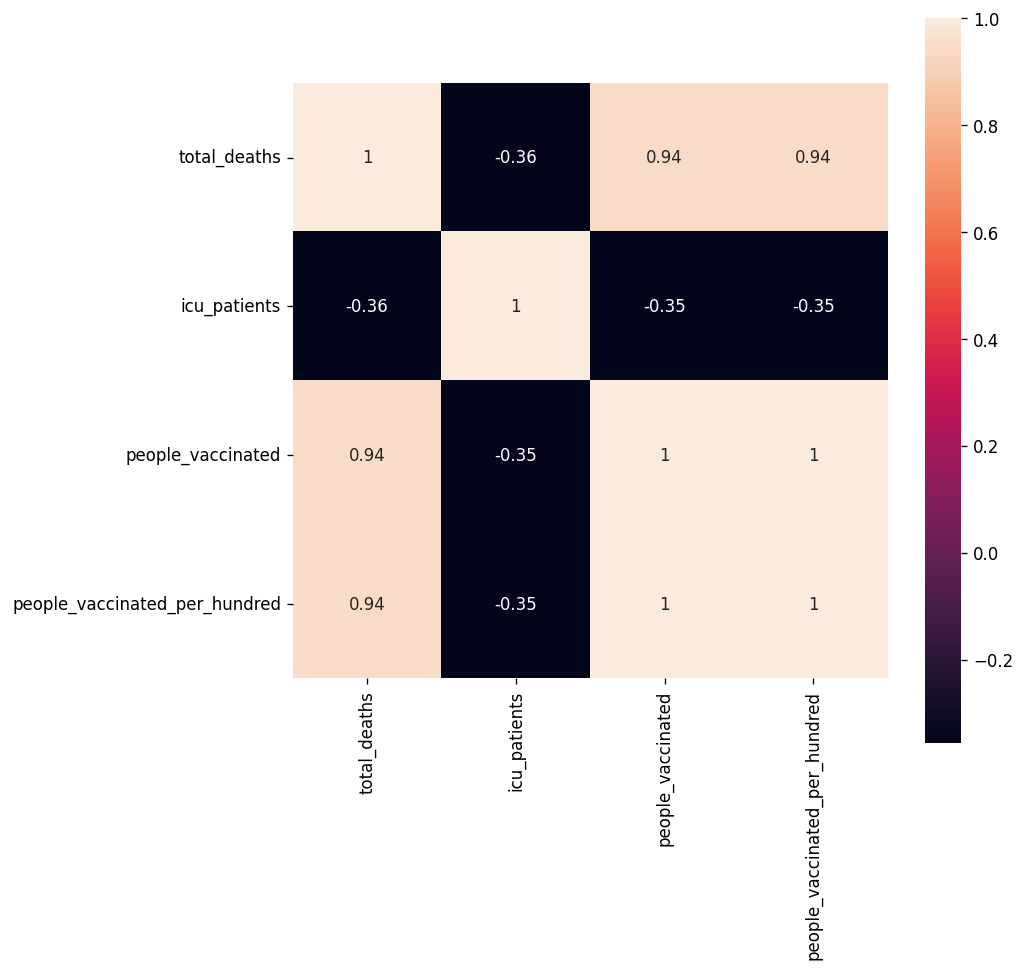

In [64]:
# Correlation matrix between the features

plt.subplots(figsize=(8, 8))
sns.heatmap(us_sndf_2_red.corr(), annot=True, square=True)
plt.show()

In [65]:
# Creating arrays for people vaccinated, amount of deaths, and amount of icu patients

death = us_sndf_2_red['total_deaths'].values
vac = us_sndf_2_red['people_vaccinated'].values
icu = us_sndf_2_red['icu_patients'].values

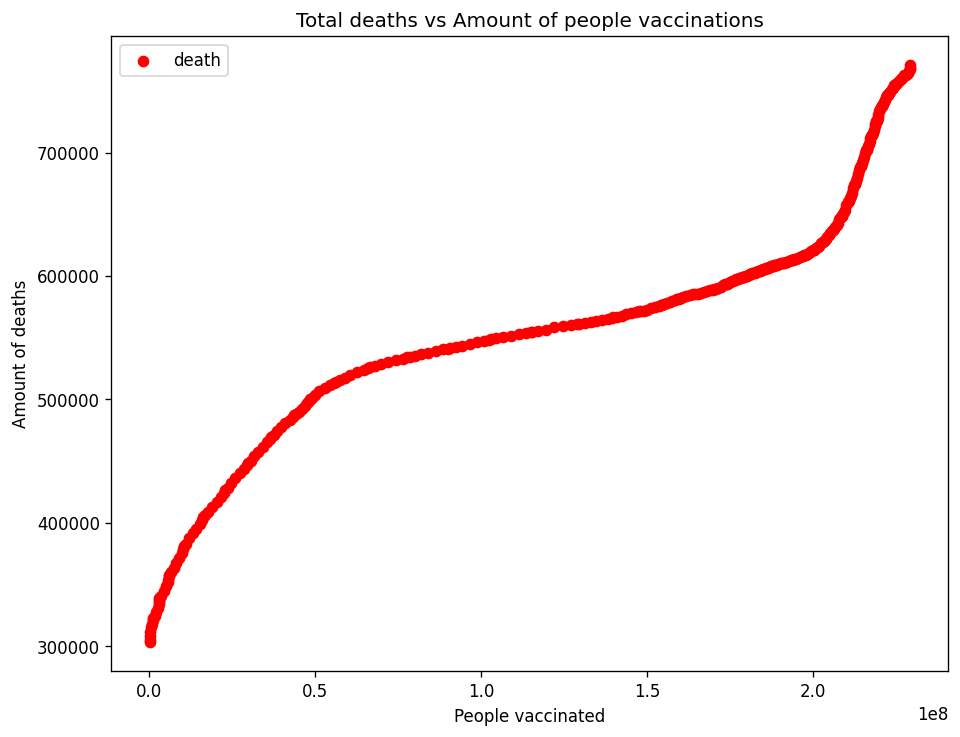

In [66]:
plt.scatter(vac, death, c='r', label='death')
plt.xlabel('People vaccinated')
plt.ylabel('Amount of deaths')
plt.title('Total deaths vs Amount of people vaccinations')
plt.legend()
plt.show()

From this graph we can see that before the vaccine came out, there were many deaths related to covid. This is due to the fact that it took a while for the vaccine rollout to occur. As vaccines progressively came out, the rate of deaths decreased, we can see the slope of deaths decreasing. Lastly, the slope of deaths is exponentially increasing as of now, this may be due to the fact that new varients are out along with less strict lockdown regulations causing the vaccine to lose its effectiveness. 

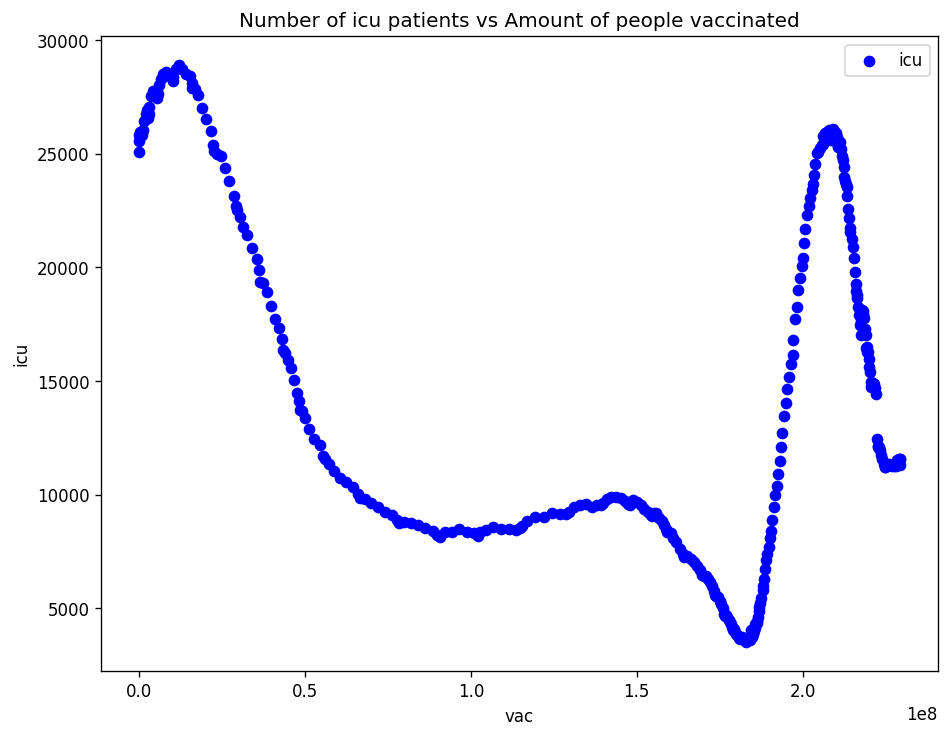

In [67]:
plt.scatter(vac, icu, c='b', label='icu')
plt.xlabel('vac')
plt.ylabel('icu')
plt.title('Number of icu patients vs Amount of people vaccinated')
plt.legend()
plt.show()

From this graph we can see that before the vaccine came out, there were many people placed into icu treatments. As the vaccines began to rollout, the number of icu patients significantly decreased with a slight peak. This may be due to new varients such as the delta variant, along with less strict lockdown regulations causing the vaccine to lose its effectiveness as well causing more elderly and sick people to require icu treatment.

In [68]:
# Perform t-test to show the relationship between amount of people vaccinated and total deaths and icu patients

from scipy.stats import ttest_ind

print(ttest_ind(vac, death))
ttest_ind(vac, icu)

Ttest_indResult(statistic=34.35911020349806, pvalue=6.270780665679408e-151)


Ttest_indResult(statistic=34.496205012715855, pvalue=1.1169178553822647e-151)

Since P-values are essentially 0, this means that the features are statistically significant (the differences between your groups are significant).

In [69]:
# Will use vaccination rate to predict amount of deaths and icu patients in the next 50 days

us_val = us_sndf_2_red['people_vaccinated_per_hundred'].values
fc, confint = stepwise_fit.predict(n_periods=n_periods, return_conf_int=True, alpha=0.80)

In [70]:
# Estimating amount of deaths using linear regression

from sklearn import linear_model

X = us_val.reshape(-1, 1)
y = death.reshape(-1, 1)
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

fc = fc.reshape(-1, 1)
# # now assuming some new set of data with the same columns as your training data 
death_predictions = regr.predict(fc)

In [71]:
# Estimating amount of icu patients using linear regression

from sklearn import linear_model

X = us_val.reshape(-1, 1)
y = icu.reshape(-1, 1)
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

fc = fc.reshape(-1, 1)
# # now assuming some new set of data with the same columns as your training data 
icu_predictions = regr.predict(fc)

Text(0.5, 1.0, 'Forcasted amount of deaths')

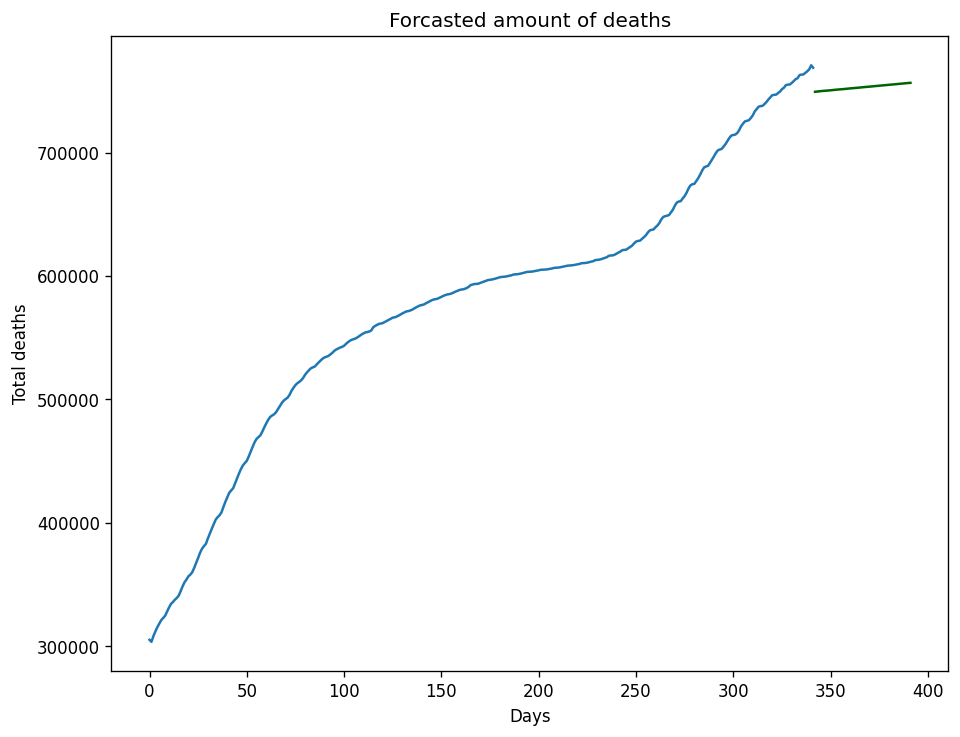

In [72]:
# Plotting forecasted amount of deaths

index_of_fc = np.arange(len(X), len(X)+n_periods)

death_predictions = death_predictions.flatten()

death_series = pd.Series(death_predictions, index=index_of_fc)

plt.plot(death)
plt.xlabel('Days')
plt.ylabel('Total deaths')
plt.plot(death_series, color='darkgreen')
plt.title("Forcasted amount of deaths")

This model doesn't make sense since we see the forecasted number of deaths lower than the last recorded amount of deaths. This model can be fine-tuned by using a different regression model. We can also add a constraint such that the first value should coincide with the last recorded amount of deaths.

Text(0.5, 1.0, 'Forcasted amount of icu patients')

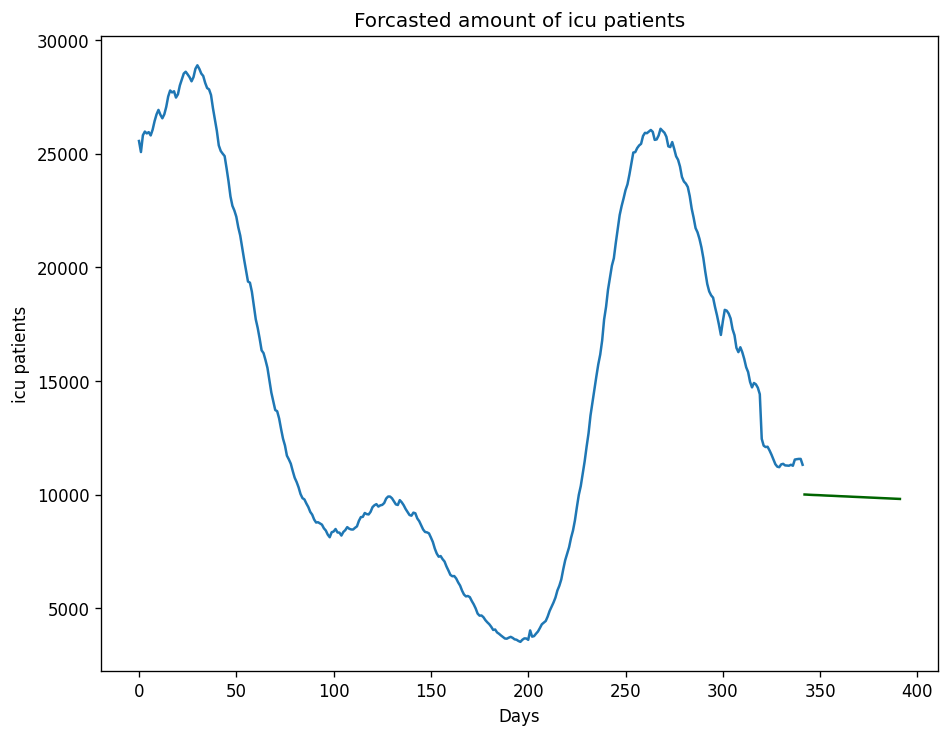

In [73]:
# Plotting forecasted amount of icu patients
index_of_fc = np.arange(len(X), len(X)+n_periods)

icu_predictions = icu_predictions.flatten()

icu_series = pd.Series(icu_predictions, index=index_of_fc)

plt.plot(icu)
plt.xlabel('Days')
plt.ylabel('icu patients')
plt.plot(icu_series, color='darkgreen')
plt.title("Forcasted amount of icu patients")

We can see that the forcasted amount of icu patients is higher. This model can be fine-tuned by using a different regression model since we can see that the trend doesn't seem to follow a linear model.

**Part 5 - Deriving Insights about the effects of vaccination and discussion**

I compared Canada with it's neighboring country, the United States. 

In terms of which country has the most effective vaccination program, it seems that currently Canada is doing better in terms of vaccination rate with 79.21% of the population being vaccinated compared to US vaccination rate of 68.5%. 

**Canada**:
I used the ARIMA model to forecast the vaccination rate after 50 days which will be 80.79% (a 1.58% increase). From our base case model, we can predict that 30,770,417 people will be vaccinated in Canada by the end of the next 50 days (from the last day of the dataset). This means 618,211 more people will be vaccinated.

**US**:
I used the ARIMA model to forecast the vaccination rate after 50 days which will be 71.57% (a 3.07% increase, almost double that as of Canada's).
From our base case model, we can predict that 240,826,270 people will be vaccinated in the US by the end of the next 50 days (from the last day of the dataset). This means 10,527,526 more people will be vaccinated.

There may be many factors or features affecting the vaccination rate in a country. This simple time series analysis by ARIMA forecasting equation is only considering a linear relationship between the days and vaccination rate in which the predictors comprised of lags of the dependent feature (here vaccination rate) and lags of the forecasting errors.

**Amount of Deaths vs Amount of People Vaccinated**: 
Plotting the amount of deaths due to covid vs the amount of people vaccinated, I can observe that the Canadian trend is very similar to the US trend. We can see that before the vaccine came out, there were many deaths related to covid. This is due to the fact that it took a while for the vaccine rollout to occur. As vaccines progressively came out, the rate of deaths decreased, we can see the rate of deaths decreasing (flattening the curve). Lastly, the slope of deaths is exponentially increasing as of now, this may be due to many factors, such that new varients are out along with less strict lockdown regulations causing the vaccine to lose its effectiveness.

Canada has 29,533 deaths with a population of 38066161

US has 770,691 deaths with a population of 332915074

US/ Canada Population = 8.74

US / Canada Deaths = 26.09

From this, we can observe that US only has a population size of 8.74x greater than Canada but yet 26.09x more deaths due to covid. This may be due to lack of healthcare in the US. This may also be due to the fact that it has a lower vaccination rate than in Canada and a cultural difference between freedom and social distancing and lockdown protocols. 

**Number of icu patients vs Amount of People Vaccinated**: 
Plotting the amount of icu patients vs the amount of people vaccinated, I can observe that the Canadian trend is vsomwehat similar to the US trend.
From this graph we can see that before the vaccine came out, there were many people placed into icu treatments. As the vaccines began to rollout, the number of icu patients significantly decreased with a slight peak. This may be due to new varients such as the delta variant, along with less strict lockdown regulations causing the vaccine to lose its effectiveness as well causing more elderly and sick people to require icu treatment.

Canada has 468 icu patients with a population of 38066161

US has 11,315 icu patients with a population of 332915074

US/ Canada Population = 8.74

US / Canada icu patients = 24.17

From this, we can observe that US only has a population size of 8.74x greater than Canada but yet 24.17x icu_patients. It seems that getting covid in the US is much more serious and life threatening compared to Canada. This may also be due to the fact that it has a lower vaccination rate than in Canada and a cultural difference between freedom and social distancing and lockdown protocols. 

Canada has much more effective vaccination program vs the US based on the number of deaths and icu patients, as Canada has much less deaths and icu patient relative to the population size. 